In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import pprint

In [2]:
df = pd.read_csv('Agri_all.csv')

In [3]:
df['YM'] = df['YM'].astype('str')

In [4]:
df

YMD      YM    MD Product         Price  KRW_USD_EXR  \
0      2005-01-03  200501   103      마늘  20785.714286      1013.00   
1      2005-01-04  200501   104      마늘  20785.714286      1013.00   
2      2005-01-05  200501   105      마늘  20928.571429      1013.00   
3      2005-01-06  200501   106      마늘  21071.428571      1013.00   
4      2005-01-07  200501   107      마늘  21071.428571      1013.00   
...           ...     ...   ...     ...           ...          ...   
15875  2020-12-24  202012  1224     고구마  10258.695652      1180.05   
15876  2020-12-28  202012  1228     고구마  10431.323529      1180.05   
15877  2020-12-29  202012  1229     고구마  10431.323529      1180.05   
15878  2020-12-30  202012  1230     고구마  10460.735294      1180.05   
15879  2020-12-31  202012  1231     고구마  10700.294118      1180.05   

       Annual_Call_Rate  item_PPI  item_CPI  Food_Price_Index  \
0                  3.33     49.58     58.27              65.4   
1                  3.33     49.58     58.27              65.4   
2                  3.33     49.58     58.27              65.4   
3                  3.33     49.58     58.27              65.4   
4                  3.33     49.58     58.27              65.4   
...                 ...       ...       ...               ...   
15875              0.70    137.90     96.13             108.6   
15876              0.70    137.90     96.13             108.6   
15877              0.70    137.90     96.13             108.6   
15878              0.70    137.90     96.13             108.6   
15879              0.70    137.90     96.13             108.6   

       Cereals_Price_Index  DayAvg_Temperature  DayDiff_Temperature  \
0                     60.5            4.400000            12.800000   
1                     60.5           -0.200000             8.800000   
2                     60.5           -1.400000            11.200000   
3                     60.5            2.800000             7.800000   
4                     60.5            2.000000             7.600000   
...                    ...                 ...                  ...   
15875                116.4            3.529412             8.588235   
15876                116.4            3.941176            11.941176   
15877                116.4            1.590909             9.227273   
15878                116.4           -5.500000             6.250000   
15879                116.4           -5.222222             9.222222   

       DayAvg_RelativeHumidity  DaySum_Rainfall  DayAvg_WindSpeed  \
0                    35.200000         0.000000          2.600000   
1                    26.000000         0.000000          2.800000   
2                    33.400000         0.000000          0.600000   
3                    31.200000         1.200000          1.200000   
4                    28.400000         0.000000          2.800000   
...                        ...              ...               ...   
15875                59.117647         0.000000          1.705882   
15876                80.352941         0.058824          0.411765   
15877                77.227273         1.272727          1.863636   
15878                65.375000         0.291667          3.958333   
15879                66.944444         0.333333          1.666667   

       DaySum_Sunshine  Warning_Count  
0             1.600000       0.000000  
1             2.800000       0.000000  
2             3.200000       0.000000  
3             2.600000       0.000000  
4             2.800000       0.000000  
...                ...            ...  
15875         3.529412       0.000000  
15876         3.117647       0.000000  
15877         0.636364       0.772727  
15878         2.666667       0.833333  
15879         3.611111       0.555556  

[15880 rows x 18 columns]

# 소비자 물가지수와 생산자 물가지수의 시점 조정
### 해당 달의 가격을 기반으로 산출되는 물가지수를 해당 달의 가격 예측을 위한 Feature로 사용할 수는 없기 때문

In [5]:
df_sub = df[['YM', 'Product', 'item_PPI', 'item_CPI']]

In [6]:
garlic_sub = df_sub[df_sub['Product']=='마늘'].groupby('YM')['item_PPI', 'item_CPI'].mean()
potato_sub = df_sub[df_sub['Product']=='감자'].groupby('YM')['item_PPI', 'item_CPI'].mean()
sweetpotato_sub = df_sub[df_sub['Product']=='고구마'].groupby('YM')['item_PPI', 'item_CPI'].mean()
perilla_sub = df_sub[df_sub['Product']=='깻잎'].groupby('YM')['item_PPI', 'item_CPI'].mean()

C:\Users\Maplexz\AppData\Local\Temp\ipykernel_2300\2257931383.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  garlic_sub = df_sub[df_sub['Product']=='마늘'].groupby('YM')['item_PPI', 'item_CPI'].mean()
C:\Users\Maplexz\AppData\Local\Temp\ipykernel_2300\2257931383.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  potato_sub = df_sub[df_sub['Product']=='감자'].groupby('YM')['item_PPI', 'item_CPI'].mean()
C:\Users\Maplexz\AppData\Local\Temp\ipykernel_2300\2257931383.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sweetpotato_sub = df_sub[df_sub['Product']=='고구마'].groupby('YM')['item_PPI', 'item_CPI'].mean()
C:\Users\Maplexz\AppData\Local\Temp\ipykernel_2300\2257931383.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a t

In [7]:
garlic_sub = garlic_sub.reset_index()
potato_sub = potato_sub.reset_index()
sweetpotato_sub = sweetpotato_sub.reset_index()
perilla_sub = perilla_sub.reset_index()

In [8]:
for i, j in enumerate(garlic_sub['YM']):
    garlic_sub.loc[i, 'YM'] = str(int(j)+2) # 2개월씩 더하기 위해 월에 2를 더해줌

for i, j in enumerate(garlic_sub['YM']):
    if j[-2:] == '13':
        garlic_sub.loc[i, 'YM'] = str(int(j[:-2])+1)+'01' # 11월의 경우 13이 되어 연도를 1 올리고 1월로 바꿔줌
    elif j[-2:] == '14':
        garlic_sub.loc[i, 'YM'] = str(int(j[:-2])+1)+'02' # 12월의 경우 14가 되어 연도를 1 올리고 2월로 바꿔줌
        
garlic_sub = garlic_sub[~garlic_sub['YM'].map(lambda x:x[:-2]=='2021')] # 가격 데이터는 20년까지밖에 없기때문에 21년으로 바뀐 데이터 삭제
garlic_sub = garlic_sub.set_index('YM')


for i, j in enumerate(potato_sub['YM']):
    potato_sub.loc[i, 'YM'] = str(int(j)+2)
    
for i, j in enumerate(potato_sub['YM']):
    if j[-2:] == '13':
        potato_sub.loc[i, 'YM'] = str(int(j[:-2])+1)+'01'
    elif j[-2:] == '14':
        potato_sub.loc[i, 'YM'] = str(int(j[:-2])+1)+'02'
        
potato_sub = potato_sub[~potato_sub['YM'].map(lambda x:x[:-2]=='2021')]
potato_sub = potato_sub.set_index('YM')


for i, j in enumerate(sweetpotato_sub['YM']):
    sweetpotato_sub.loc[i, 'YM'] = str(int(j)+2)
    
for i, j in enumerate(sweetpotato_sub['YM']):
    if j[-2:] == '13':
        sweetpotato_sub.loc[i, 'YM'] = str(int(j[:-2])+1)+'01'
    elif j[-2:] == '14':
        sweetpotato_sub.loc[i, 'YM'] = str(int(j[:-2])+1)+'02'
        
sweetpotato_sub = sweetpotato_sub[~sweetpotato_sub['YM'].map(lambda x:x[:-2]=='2021')]
sweetpotato_sub = sweetpotato_sub.set_index('YM')


for i, j in enumerate(perilla_sub['YM']):
    perilla_sub.loc[i, 'YM'] = str(int(j)+2)
    
for i, j in enumerate(perilla_sub['YM']):
    if j[-2:] == '13':
        perilla_sub.loc[i, 'YM'] = str(int(j[:-2])+1)+'01'
    elif j[-2:] == '14':
        perilla_sub.loc[i, 'YM'] = str(int(j[:-2])+1)+'02'
        
perilla_sub = perilla_sub[~perilla_sub['YM'].map(lambda x:x[:-2]=='2021')]
perilla_sub = perilla_sub.set_index('YM')

# 2개월씩 더하면서 사용하지 않게된 처음 두달 데이터 삭제

In [9]:
df = df[~df['YM'].map(lambda x:((x=='200501')|(x=='200502')))]
df = df.reset_index(drop=True)
df

YMD      YM    MD Product         Price  KRW_USD_EXR  \
0      2005-03-02  200503   302      마늘  21821.428571      1013.00   
1      2005-03-03  200503   303      마늘  21821.428571      1013.00   
2      2005-03-04  200503   304      마늘  21821.428571      1013.00   
3      2005-03-07  200503   307      마늘  21821.428571      1013.00   
4      2005-03-08  200503   308      마늘  21821.428571      1013.00   
...           ...     ...   ...     ...           ...          ...   
15723  2020-12-24  202012  1224     고구마  10258.695652      1180.05   
15724  2020-12-28  202012  1228     고구마  10431.323529      1180.05   
15725  2020-12-29  202012  1229     고구마  10431.323529      1180.05   
15726  2020-12-30  202012  1230     고구마  10460.735294      1180.05   
15727  2020-12-31  202012  1231     고구마  10700.294118      1180.05   

       Annual_Call_Rate  item_PPI  item_CPI  Food_Price_Index  \
0                  3.33     48.52    59.076              67.1   
1                  3.33     48.52    59.076              67.1   
2                  3.33     48.52    59.076              67.1   
3                  3.33     48.52    59.076              67.1   
4                  3.33     48.52    59.076              67.1   
...                 ...       ...       ...               ...   
15723              0.70    137.90    96.130             108.6   
15724              0.70    137.90    96.130             108.6   
15725              0.70    137.90    96.130             108.6   
15726              0.70    137.90    96.130             108.6   
15727              0.70    137.90    96.130             108.6   

       Cereals_Price_Index  DayAvg_Temperature  DayDiff_Temperature  \
0                     61.5            1.400000             7.800000   
1                     61.5            0.000000             8.400000   
2                     61.5            0.400000             9.400000   
3                     61.5            4.600000            14.200000   
4                     61.5            6.000000            14.600000   
...                    ...                 ...                  ...   
15723                116.4            3.529412             8.588235   
15724                116.4            3.941176            11.941176   
15725                116.4            1.590909             9.227273   
15726                116.4           -5.500000             6.250000   
15727                116.4           -5.222222             9.222222   

       DayAvg_RelativeHumidity  DaySum_Rainfall  DayAvg_WindSpeed  \
0                    37.400000         0.000000          1.200000   
1                    31.800000         0.000000          1.600000   
2                    33.800000         0.400000          1.600000   
3                    31.000000         0.000000          1.800000   
4                    20.000000         0.000000          1.400000   
...                        ...              ...               ...   
15723                59.117647         0.000000          1.705882   
15724                80.352941         0.058824          0.411765   
15725                77.227273         1.272727          1.863636   
15726                65.375000         0.291667          3.958333   
15727                66.944444         0.333333          1.666667   

       DaySum_Sunshine  Warning_Count  
0             0.800000       0.000000  
1             3.400000       0.000000  
2             3.200000       0.000000  
3             5.800000       0.000000  
4             5.400000       0.000000  
...                ...            ...  
15723         3.529412       0.000000  
15724         3.117647       0.000000  
15725         0.636364       0.772727  
15726         2.666667       0.833333  
15727         3.611111       0.555556  

[15728 rows x 18 columns]

# 결측치 확인

In [10]:
df.isnull().sum()

YMD                           0
YM                            0
MD                            0
Product                       0
Price                         0
KRW_USD_EXR                   0
Annual_Call_Rate              0
item_PPI                   3932
item_CPI                      0
Food_Price_Index              0
Cereals_Price_Index           0
DayAvg_Temperature            0
DayDiff_Temperature           0
DayAvg_RelativeHumidity       0
DaySum_Rainfall               0
DayAvg_WindSpeed              0
DaySum_Sunshine               0
Warning_Count                 0
dtype: int64

In [11]:
df[df['item_PPI'].isnull()]['Product'].unique()

array(['깻잎'], dtype=object)

# 마늘

In [12]:
garlic = df.loc[df['Product']=='마늘']
garlic = pd.DataFrame(garlic.groupby('YM').mean())
garlic[['item_CPI', 'item_PPI']] = garlic_sub[['item_CPI', 'item_PPI']] # 2개월만큼의 시점을 바꿔준 PPI CPI 값을 갱신
garlic_exog = garlic.iloc[:, 1:8]
garlic = pd.DataFrame(garlic.iloc[:, 1])

<AxesSubplot: >

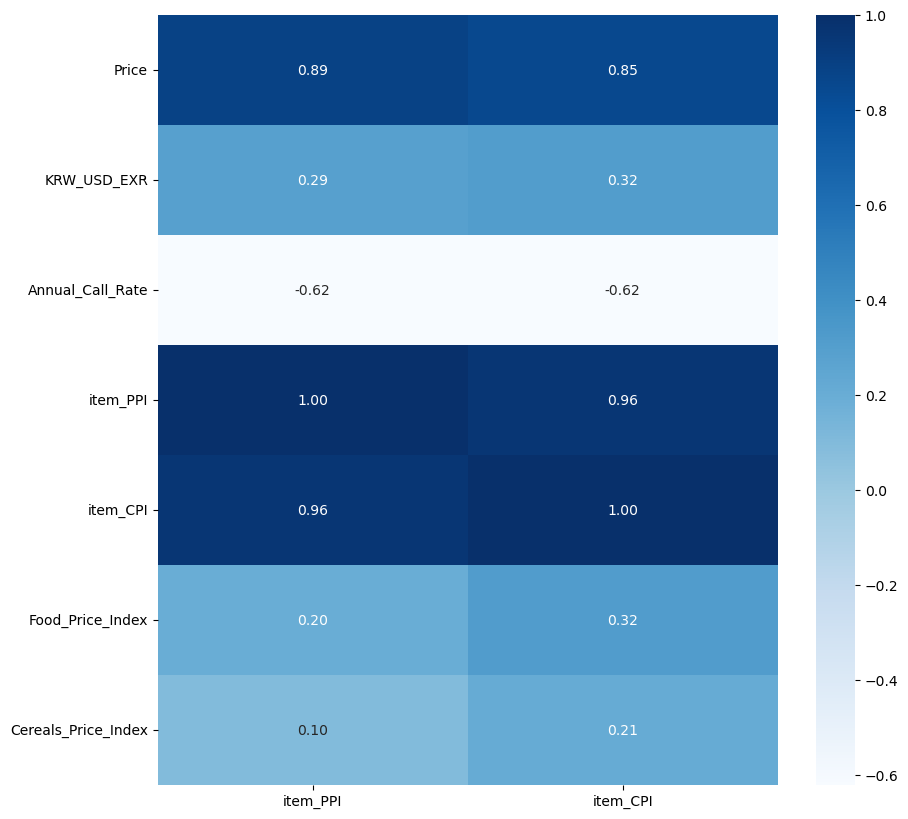

In [13]:
plt.figure(figsize=(10,10))
sns.heatmap(garlic_exog.corr()[['item_PPI', 'item_CPI']], annot=True, fmt='.2f', cmap='Blues')

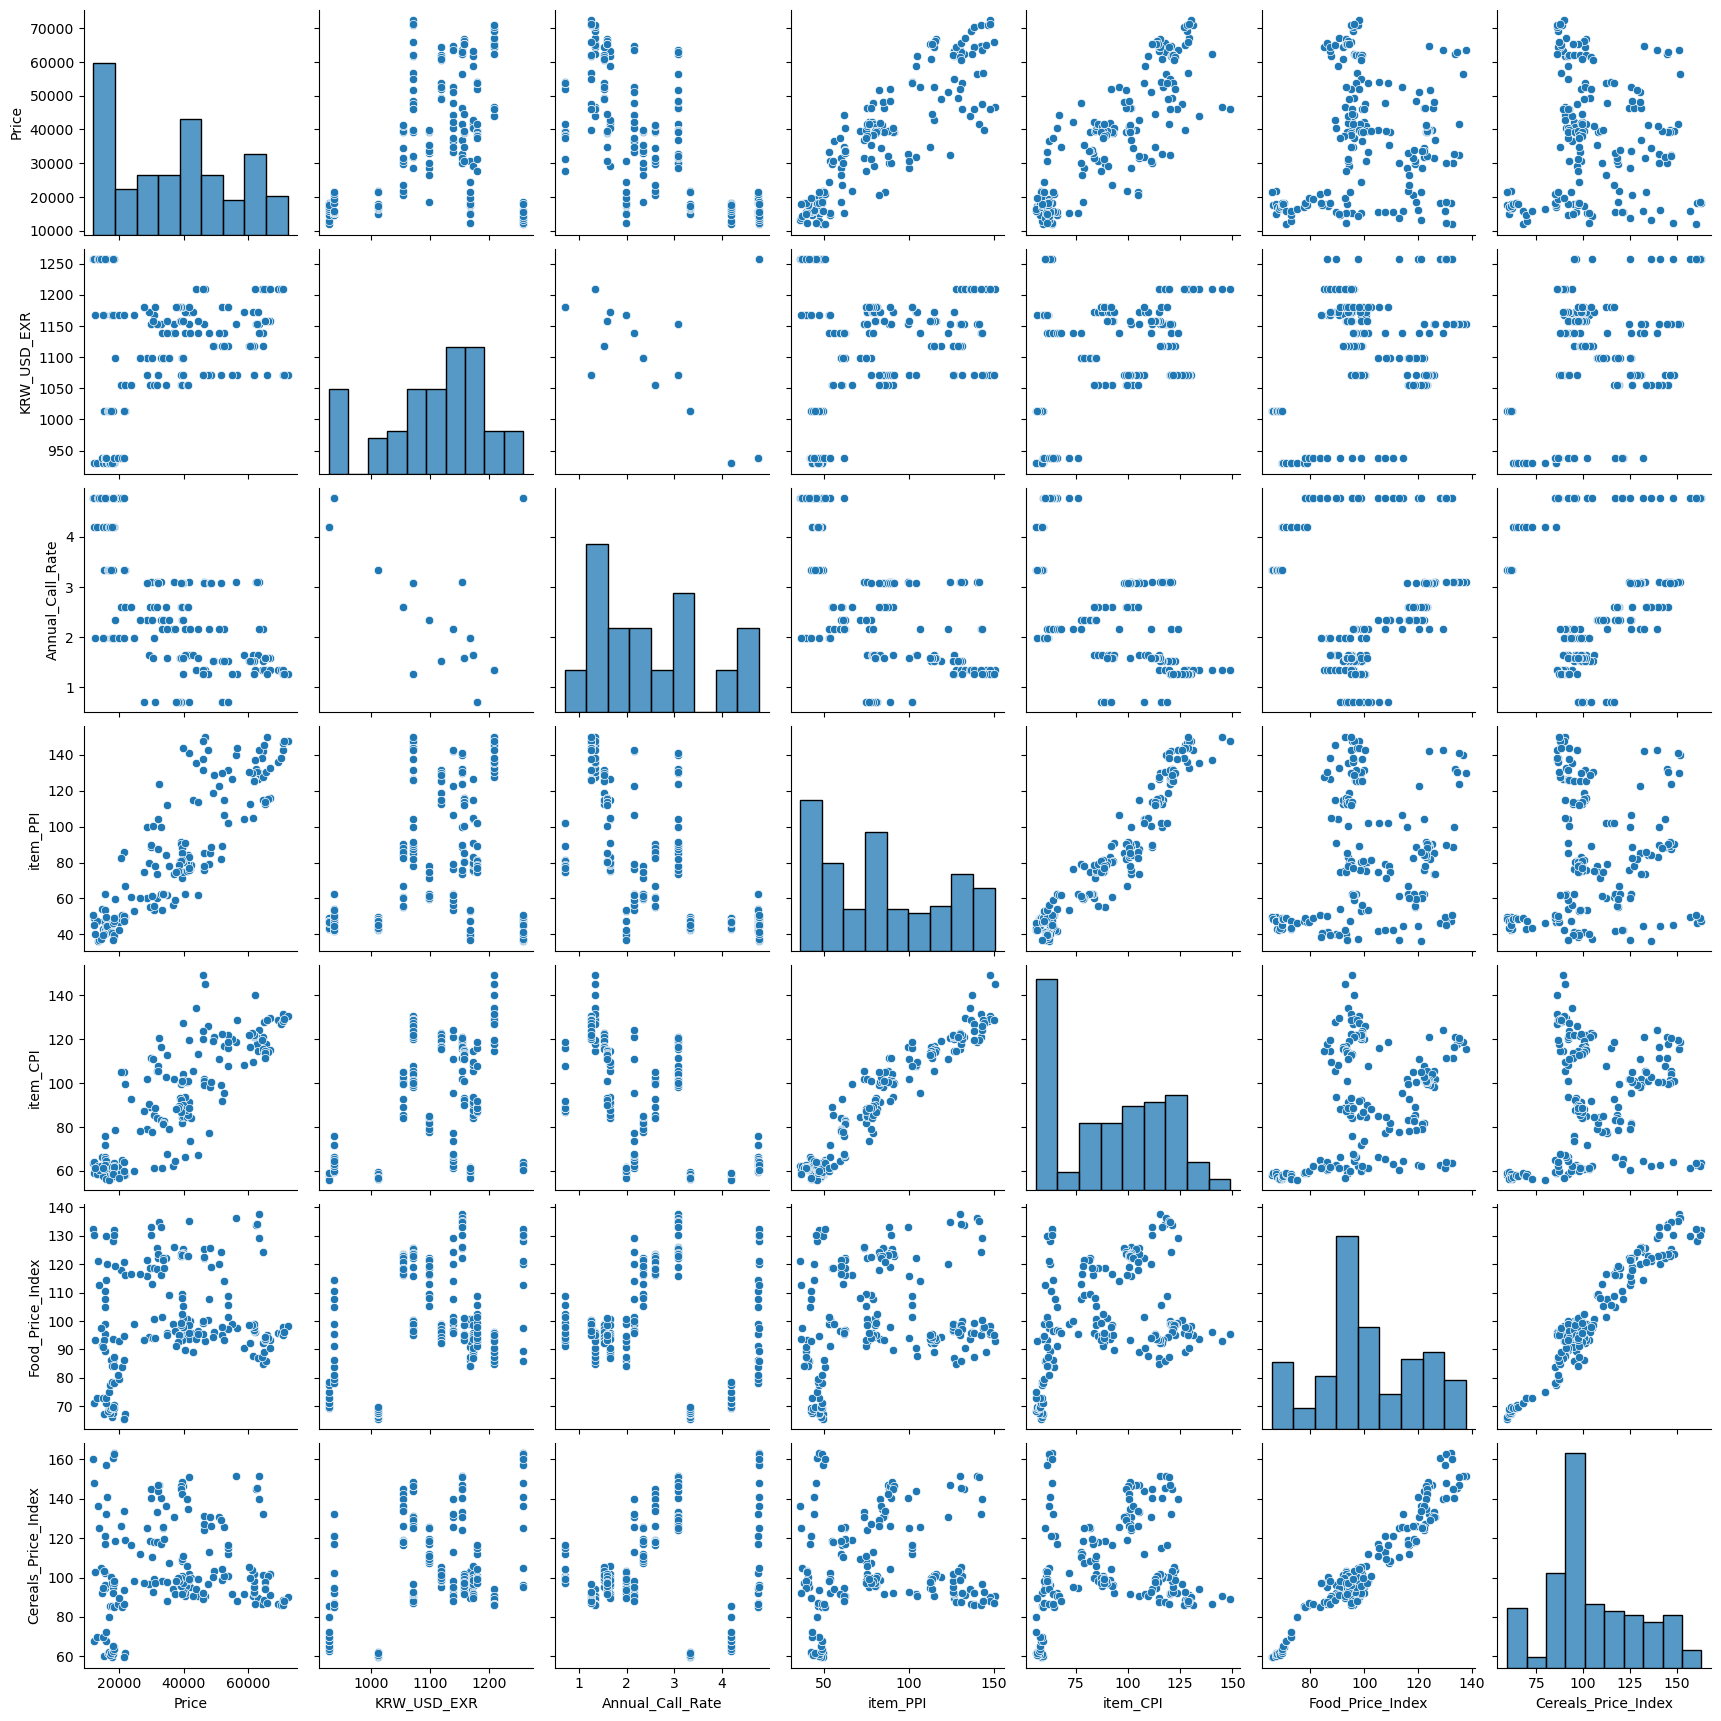

In [14]:
sns.pairplot(garlic_exog)

In [15]:
garlic_exog = garlic_exog.drop('Price', axis=1) # 외부 변수로 사용하게 될 Features

In [16]:
# ~18년까지 Training Set / 19, 20년 : Test Set
train_idx = 166
test_idx = len(garlic)-train_idx
train_idx, test_idx

(166, 24)

<AxesSubplot: xlabel='YM'>

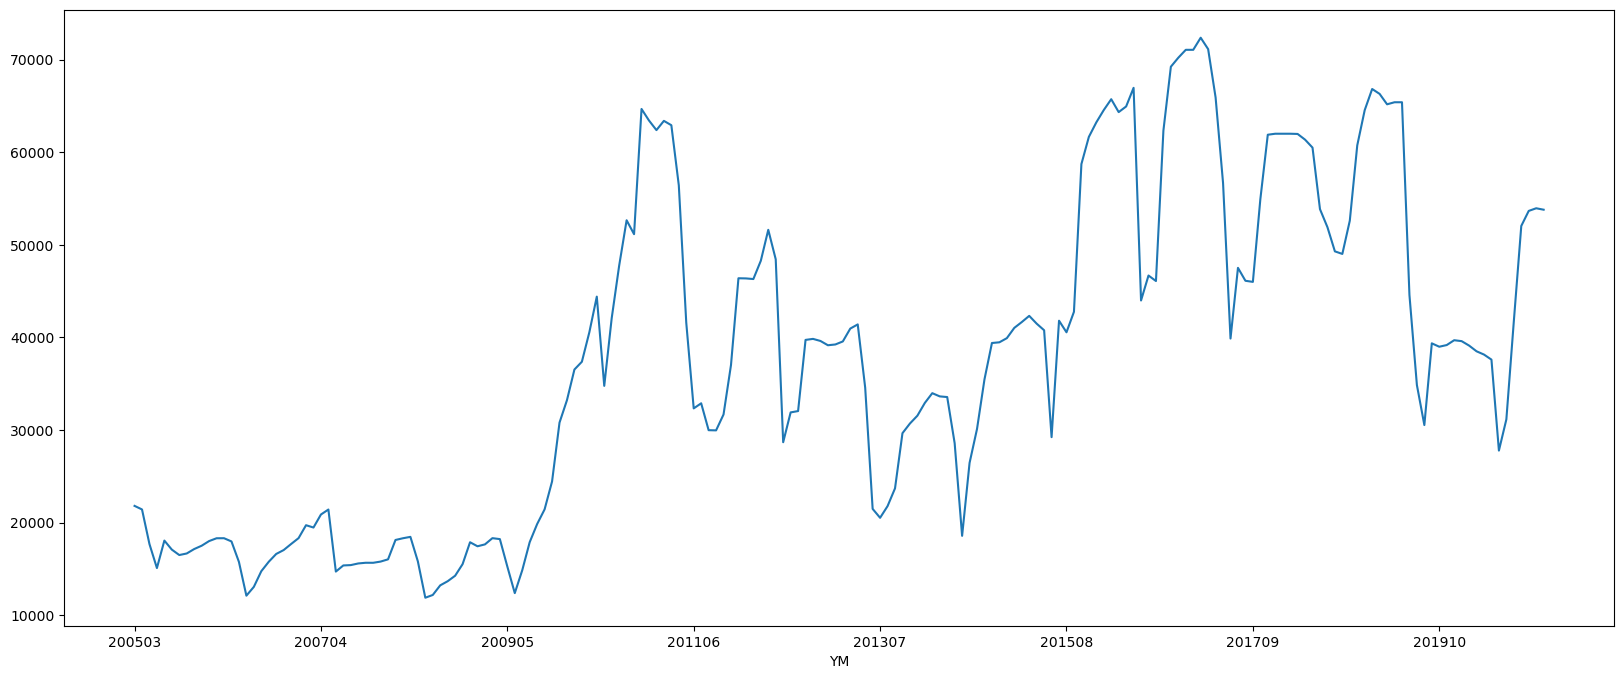

In [17]:
garlic['Price'].plot(figsize=(20,8))

In [18]:
garlic_train = garlic.iloc[:train_idx]
garlic_test = garlic.iloc[train_idx:]

In [19]:
garlic_test

Price
YM                  
201901  66831.818182
201902  66301.960784
201903  65177.777778
201904  65400.000000
201905  65400.000000
201906  44586.315789
201907  34856.521739
201908  30538.095238
201909  39362.573099
201910  38997.354497
201911  39177.248677
201912  39700.000000
202001  39600.000000
202002  39121.250000
202003  38503.977273
202004  38150.000000
202005  37605.263158
202006  27782.386364
202007  31152.898551
202008  41740.128788
202009  52040.692641
202010  53665.151515
202011  53950.000000
202012  53795.238095

# ACF PACF (p, d, q값 결정)

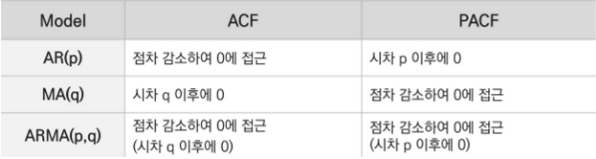

C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


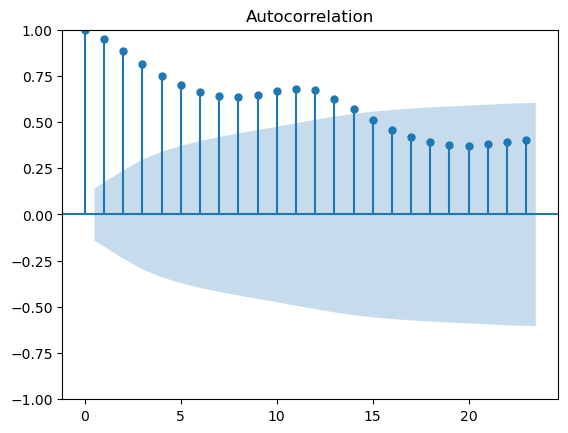

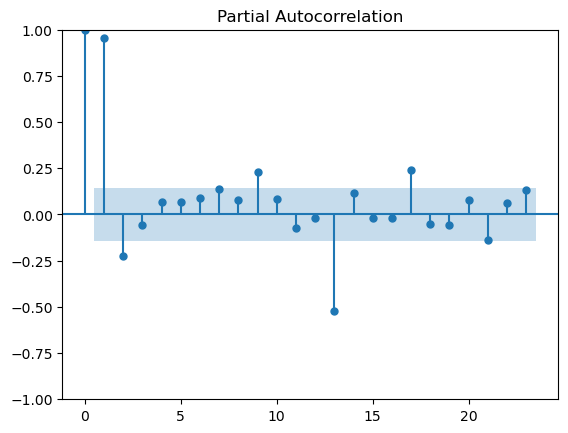

In [20]:
plot_acf(garlic)
plot_pacf(garlic)
plt.show()

# 1차 차분, 2차 차분

In [21]:
# 차분을 통해 p-value가 0.05 유의확률 아래로 내려가게 된 첫번째 값을 d값으로 채택

C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


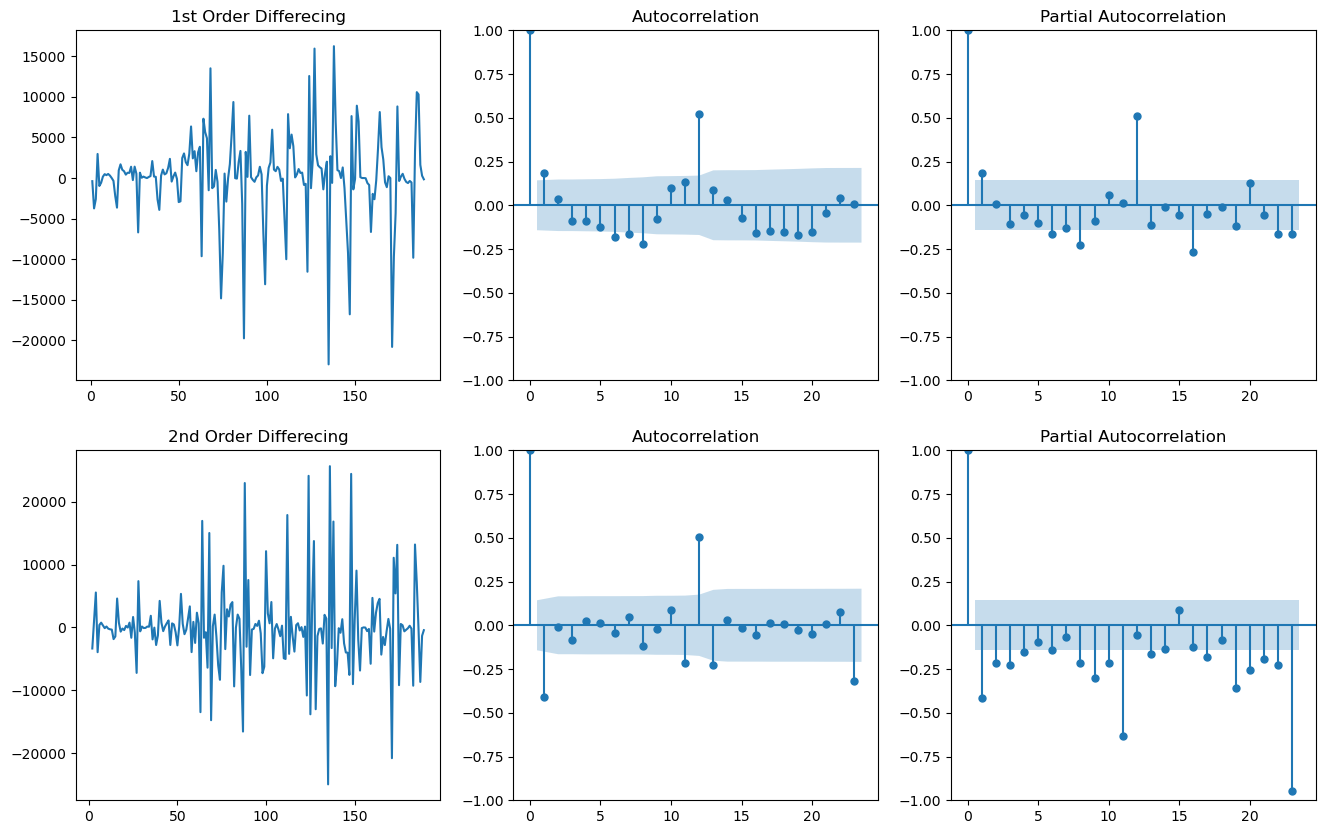

p-value:  0.19027417009186193
1st Order Diff p-value:  0.0023353414807421647
2nd Order Diff p-value:  5.792428033070244e-26


In [22]:
garlic = garlic.reset_index()

f = plt.figure(figsize=(16,10))
ax1 = f.add_subplot(231)
ax1.set_title('1st Order Differecing')
ax1.plot(garlic.Price.diff())                             #1차 차분을 수행한 후 시각화

ax2 = f.add_subplot(232)
plot_acf(garlic.Price.diff().dropna(), ax=ax2)            # 차분으로 생긴 공백값을 처리하고 시각화

ax3 = f.add_subplot(233)
plot_pacf(garlic.Price.diff().dropna(), ax=ax3)

ax4 = f.add_subplot(234)
ax4.set_title('2nd Order Differecing')
ax4.plot(garlic.Price.diff().diff())                      # 2차 차분

ax5 = f.add_subplot(235)
plot_acf(garlic.Price.diff().diff().dropna(), ax=ax5)

ax6 = f.add_subplot(236)
plot_pacf(garlic.Price.diff().diff().dropna(), ax=ax6)

plt.show()

garlic.index=garlic['YM']
garlic = garlic.drop('YM', axis=1)

result = adfuller(garlic.Price.dropna())            # ADF Test를 수행하는 api
print('p-value: ', result[1])                       # 순서대로 p-value / test-statistics / critical value / lag, observation 정보를
                                                    # 반환해주기 때문에 이들 중 1번째 값만 받아와 사용
result = adfuller(garlic.Price.diff().dropna())
print('1st Order Diff p-value: ', result[1])

result = adfuller(garlic.Price.diff().diff().dropna())
print('2nd Order Diff p-value: ', result[1])

# ARIMA Model

In [23]:
model=ARIMA(garlic['Price'], order=(2,1,3))
history=model.fit()

C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting M

In [24]:
history.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  190
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -1869.546
Date:                Wed, 04 Jan 2023   AIC                           3751.092
Time:                        18:51:13   BIC                           3770.543
Sample:                             0   HQIC                          3758.972
                                - 190                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7175      0.014    119.755      0.000       1.689       1.746
ar.L2         -0.9936      0.013    -76.108      0.000      -1.019      -0.968
ma.L1         -1.7338      0.070    -24.701      0.000      -1.871      -1.596
ma.L2          1.0608      0.111      9.558      0.000       0.843       1.278
ma.L3         -0.0428      0.073     -0.582      0.560      -0.187       0.101
sigma2      2.552e+07   3.95e-09   6.46e+15      0.000    2.55e+07    2.55e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):               124.71
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               6.02   Skew:                            -0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.38e+30. Standard errors may be unstable.
"""

<AxesSubplot: xlabel='YM'>

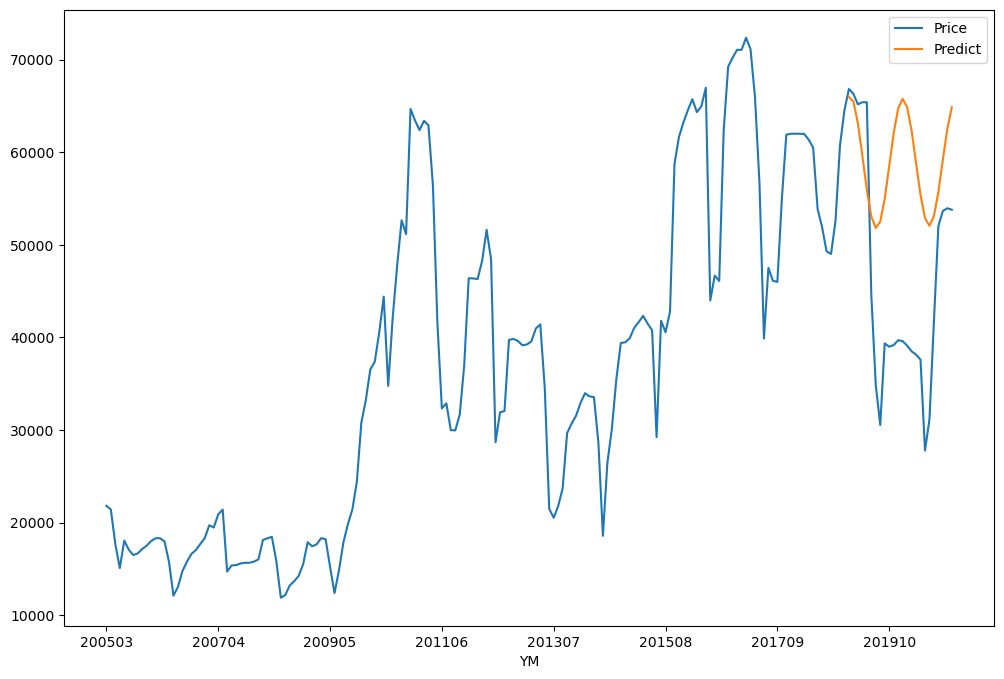

In [25]:
garlic['Predict']=history.predict(start=train_idx, end=train_idx+test_idx-1, dynamic=True)
garlic[['Price','Predict']].plot(figsize=(12,8))

In [26]:
y_true = garlic[~garlic['Predict'].isna()]['Price']
y_pred = garlic[~garlic['Predict'].isna()]['Predict']

mape = np.mean(np.abs(y_pred - y_true) / np.abs(y_true))
mae = np.mean(np.abs(y_pred - y_true))
mpe = np.mean((y_pred-y_true)/y_true)
rmse = np.mean((y_pred - y_true)**2)**.5


pprint.pprint({'mape':mape, 'mae':mae,
       'mpe':mpe, 'rmse':rmse})

{'mae': 14581.620969179678,
 'mape': 0.3807545954970735,
 'mpe': 0.35660929642550926,
 'rmse': 16887.131577600278}


# SARIMAX Model

# PPI CPI 제외하고 학습

C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot: xlabel='YM'>

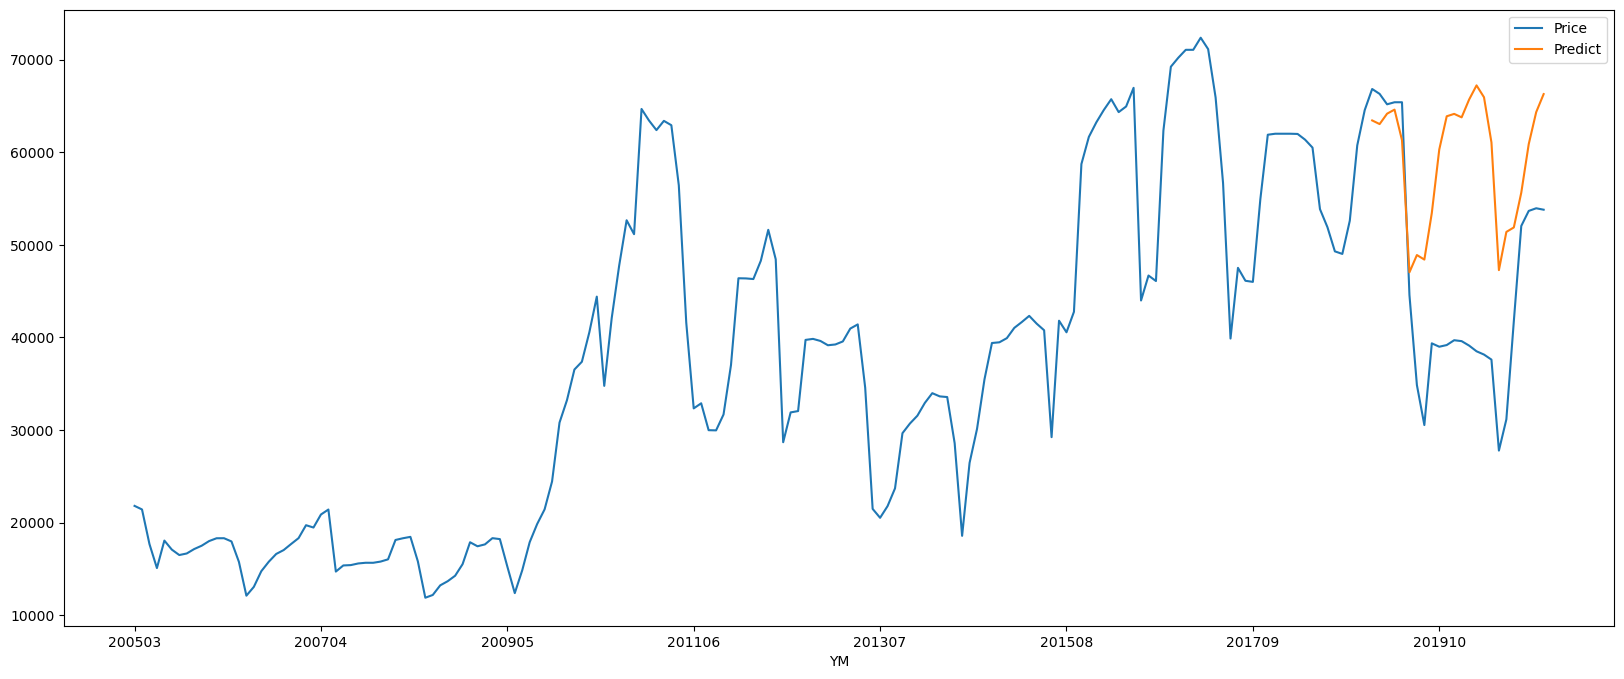

In [27]:
model=sm.tsa.statespace.SARIMAX(garlic['Price'],
                                exog=garlic_exog[['Annual_Call_Rate', 'KRW_USD_EXR', 'Food_Price_Index', 'Cereals_Price_Index']],
                                order=(2, 1, 3),
                                seasonal_order=(2,1,3,12) # 계절성 데이터이기 때문에 m=12 를 채택
                               )
results=model.fit()

garlic['Predict']=results.predict(start=train_idx, end=train_idx+test_idx-1, dynamic=True)
garlic[['Price','Predict']].plot(figsize=(20,8))

In [28]:
y_true = garlic[~garlic['Predict'].isna()]['Price']
y_pred = garlic[~garlic['Predict'].isna()]['Predict']

mape = np.mean(np.abs(y_pred - y_true) / np.abs(y_true))
mae = np.mean(np.abs(y_pred - y_true))
mpe = np.mean((y_pred-y_true)/y_true)
rmse = np.mean((y_pred - y_true)**2)**.5


pprint.pprint({'mape':mape, 'mae':mae,
       'mpe':mpe, 'rmse':rmse})

{'mae': 14403.543438148075,
 'mape': 0.37470268597879425,
 'mpe': 0.35884579109049364,
 'rmse': 17176.444828881282}


# PPI CPI로만 학습

C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot: xlabel='YM'>

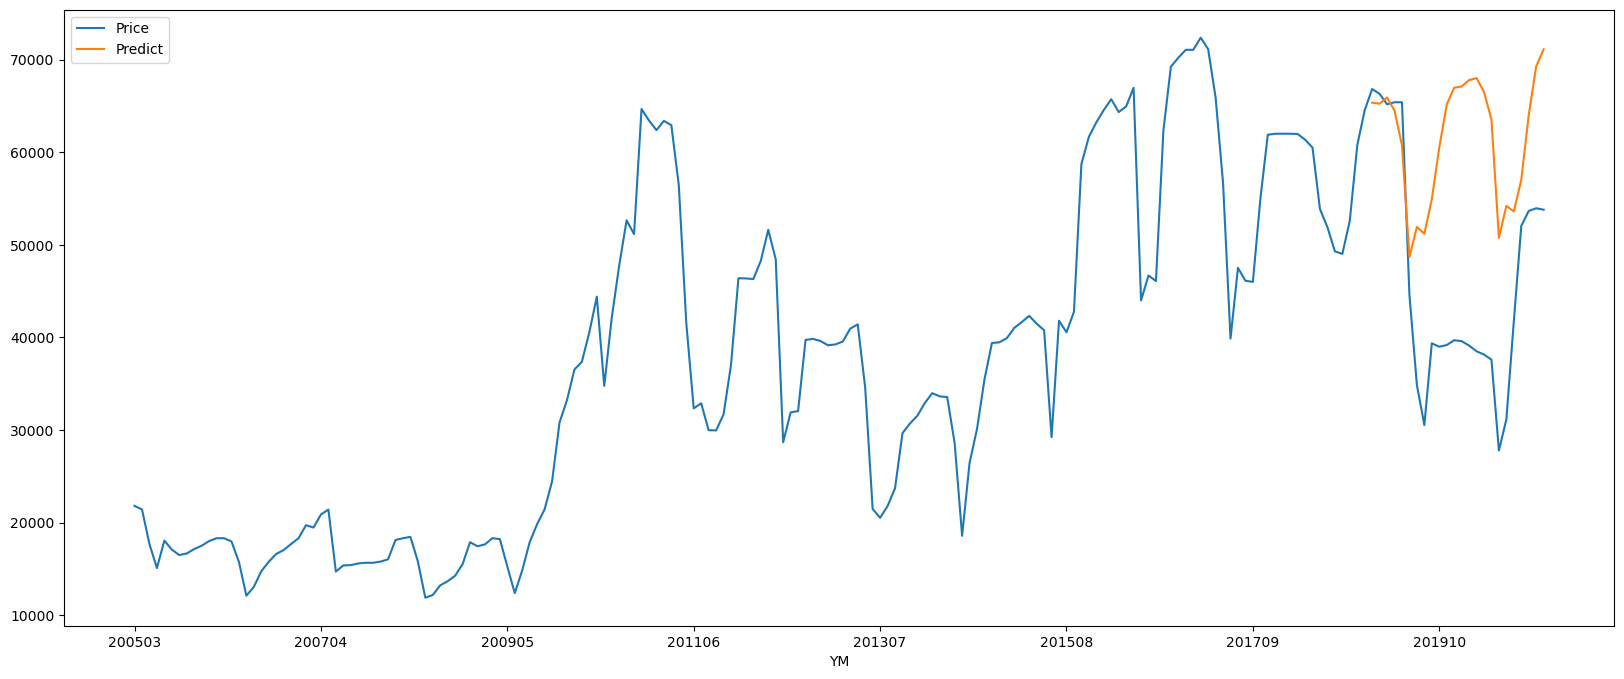

In [29]:
model=sm.tsa.statespace.SARIMAX(garlic['Price'],
                                exog=garlic_exog[['item_PPI', 'item_CPI']],
                                order=(2, 1, 3),
                                seasonal_order=(2,1,3,12)
                               )
results=model.fit()

garlic['Predict']=results.predict(start=train_idx, end=train_idx+test_idx-1, dynamic=True)
garlic[['Price','Predict']].plot(figsize=(20,8))

In [30]:
y_true = garlic[~garlic['Predict'].isna()]['Price']
y_pred = garlic[~garlic['Predict'].isna()]['Predict']

mape = np.mean(np.abs(y_pred - y_true) / np.abs(y_true))
mae = np.mean(np.abs(y_pred - y_true))
mpe = np.mean((y_pred-y_true)/y_true)
rmse = np.mean((y_pred - y_true)**2)**.5


pprint.pprint({'mape':mape, 'mae':mae,
       'mpe':mpe, 'rmse':rmse})

{'mae': 16117.819023770795,
 'mape': 0.4192568886868777,
 'mpe': 0.4089883275233681,
 'rmse': 19014.633876758227}


# 모든 Feature로 학습

C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot: xlabel='YM'>

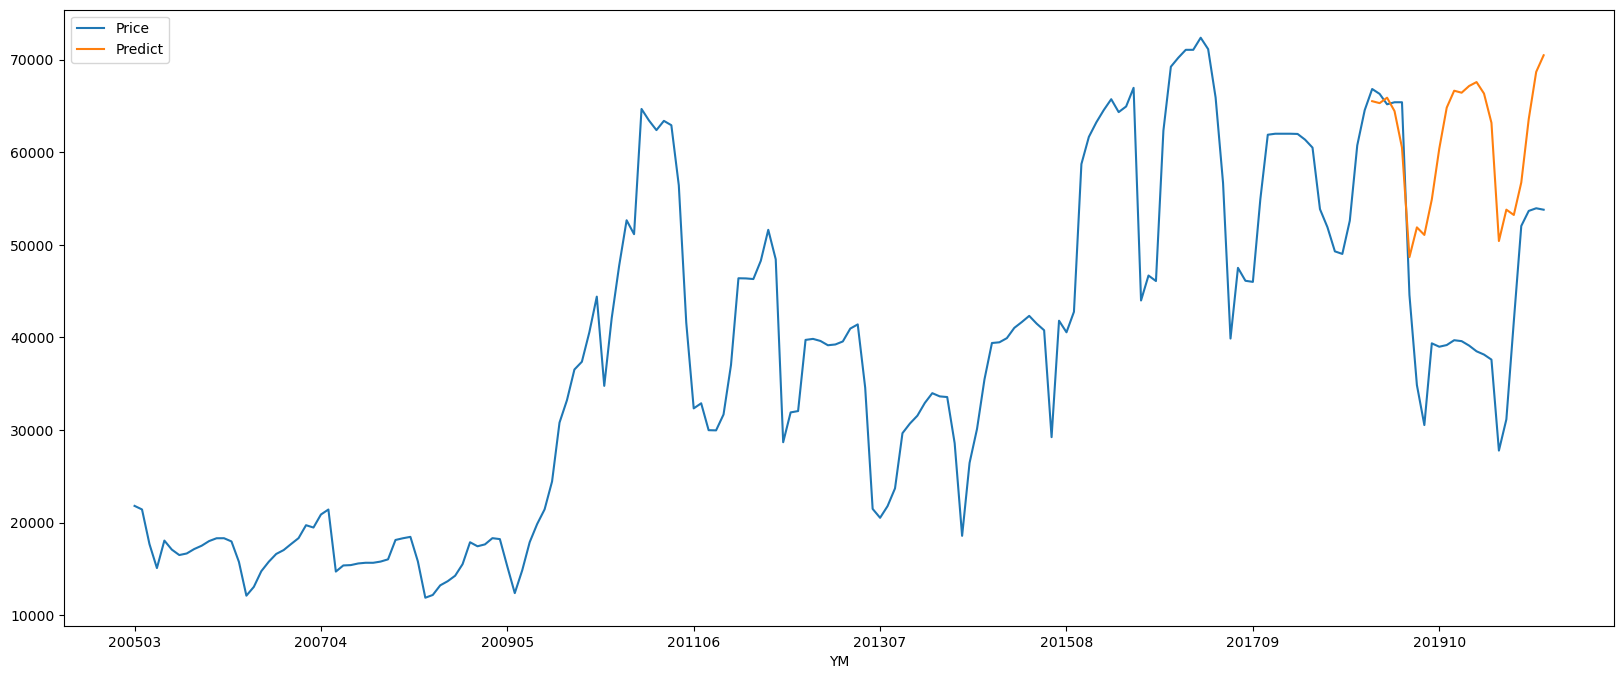

In [31]:
model=sm.tsa.statespace.SARIMAX(garlic['Price'],
                                exog=garlic_exog,
                                order=(2, 1, 3),
                                seasonal_order=(2,1,3,12)
                               )
results=model.fit()

garlic['Predict']=results.predict(start=train_idx, end=train_idx+test_idx-1, dynamic=True)
garlic[['Price','Predict']].plot(figsize=(20,8))

In [32]:
y_true = garlic[~garlic['Predict'].isna()]['Price']
y_pred = garlic[~garlic['Predict'].isna()]['Predict']

mape = np.mean(np.abs(y_pred - y_true) / np.abs(y_true))
mae = np.mean(np.abs(y_pred - y_true))
mpe = np.mean((y_pred-y_true)/y_true)
rmse = np.mean((y_pred - y_true)**2)**.5


pprint.pprint({'mape':mape, 'mae':mae,
       'mpe':mpe, 'rmse':rmse})

{'mae': 15855.33421749431,
 'mape': 0.4127972651104243,
 'mpe': 0.40243637376789293,
 'rmse': 18720.271388116787}


# 감자

In [33]:
potato = df.loc[df['Product']=='감자']
potato = pd.DataFrame(potato.groupby('YM').mean())
potato[['item_CPI', 'item_PPI']] = potato_sub[['item_CPI', 'item_PPI']]
potato_exog = potato.iloc[:, 2:8]
potato = pd.DataFrame(potato.iloc[:, 1])
potato

Price
YM                 
200503  7081.545223
200504  6834.099024
200505  6803.346901
200506  3415.293732
200507  2794.047957
...             ...
202008  4383.076468
202009  4790.924308
202010  4650.754234
202011  4889.213905
202012  4912.343088

[190 rows x 1 columns]

<AxesSubplot: xlabel='YM'>

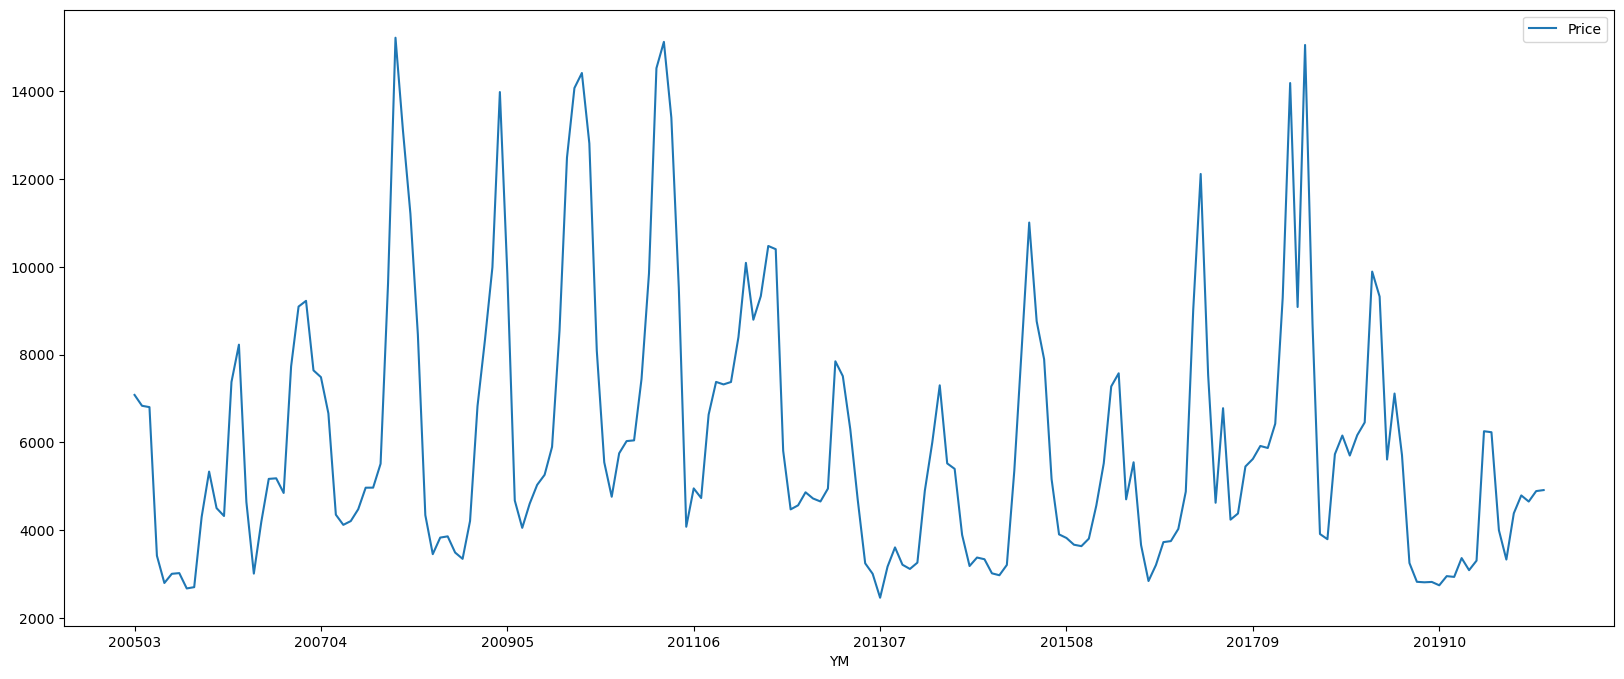

In [34]:
potato.plot(figsize=(20,8))

In [35]:
potato_train = potato.iloc[:train_idx]
potato_test = potato.iloc[train_idx:]

C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


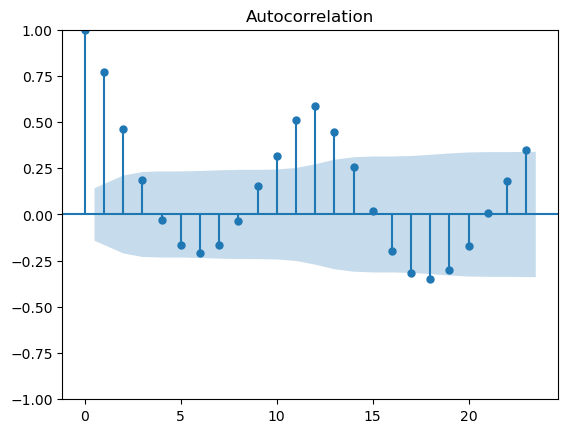

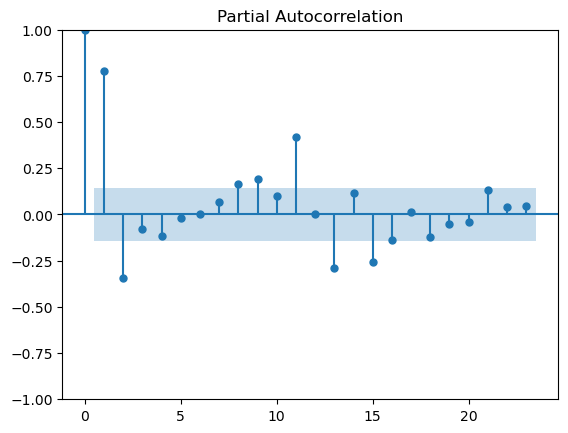

In [36]:
plot_acf(potato)
plot_pacf(potato)
plt.show()

C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


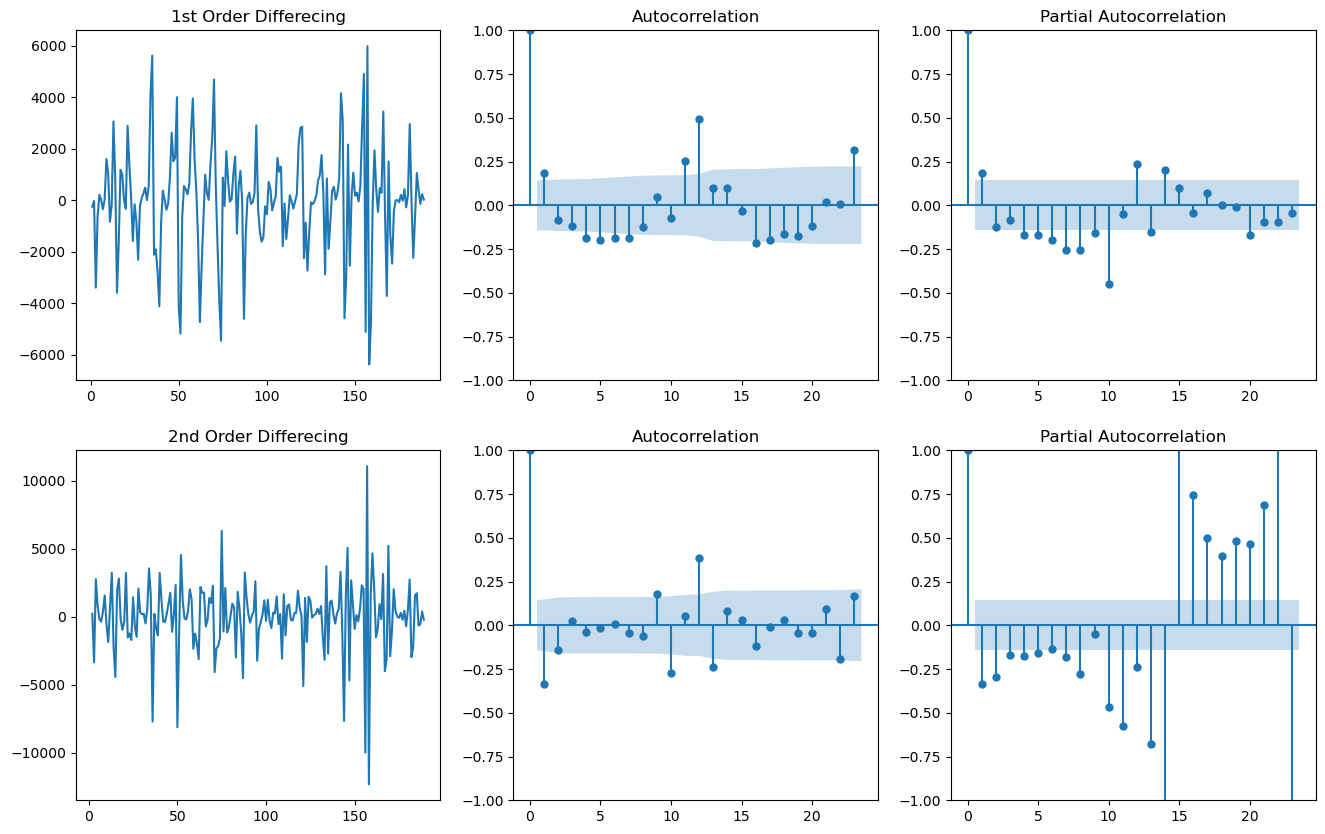

p-value:  0.1068074653265404
1st Order Diff p-value:  0.0002432197954093811
2nd Order Diff p-value:  5.3231399148474935e-17


In [37]:
potato = potato.reset_index()

f = plt.figure(figsize=(16,10))
ax1 = f.add_subplot(231)
ax1.set_title('1st Order Differecing')
ax1.plot(potato.Price.diff())

ax2 = f.add_subplot(232)
plot_acf(potato.Price.diff().dropna(), ax=ax2)

ax3 = f.add_subplot(233)
plot_pacf(potato.Price.diff().dropna(), ax=ax3)

ax4 = f.add_subplot(234)
ax4.set_title('2nd Order Differecing')
ax4.plot(potato.Price.diff().diff())

ax5 = f.add_subplot(235)
plot_acf(potato.Price.diff().diff().dropna(), ax=ax5)

ax6 = f.add_subplot(236)
plot_pacf(potato.Price.diff().diff().dropna(), ax=ax6)

plt.show()

potato.index=potato['YM']
potato = potato.drop('YM', axis=1)

result = adfuller(potato.Price.dropna())
print('p-value: ', result[1])

result = adfuller(potato.Price.diff().dropna())
print('1st Order Diff p-value: ', result[1])

result = adfuller(potato.Price.diff().diff().dropna())
print('2nd Order Diff p-value: ', result[1])

# ARIMA Model

In [38]:
model=ARIMA(potato['Price'], order=(2,1,2))
history=model.fit()

C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting M

In [39]:
history.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  190
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1673.975
Date:                Wed, 04 Jan 2023   AIC                           3357.951
Time:                        18:51:43   BIC                           3374.160
Sample:                             0   HQIC                          3364.517
                                - 190                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6285      0.048     34.114      0.000       1.535       1.722
ar.L2         -0.8686      0.042    -20.454      0.000      -0.952      -0.785
ma.L1         -1.7476      0.062    -28.255      0.000      -1.869      -1.626
ma.L2          0.8415      0.065     12.851      0.000       0.713       0.970
sigma2      2.859e+06   2.19e+05     13.066      0.000    2.43e+06    3.29e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                54.53
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               1.44   Skew:                             0.76
Prob(H) (two-sided):                  0.15   Kurtosis:                         5.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot: xlabel='YM'>

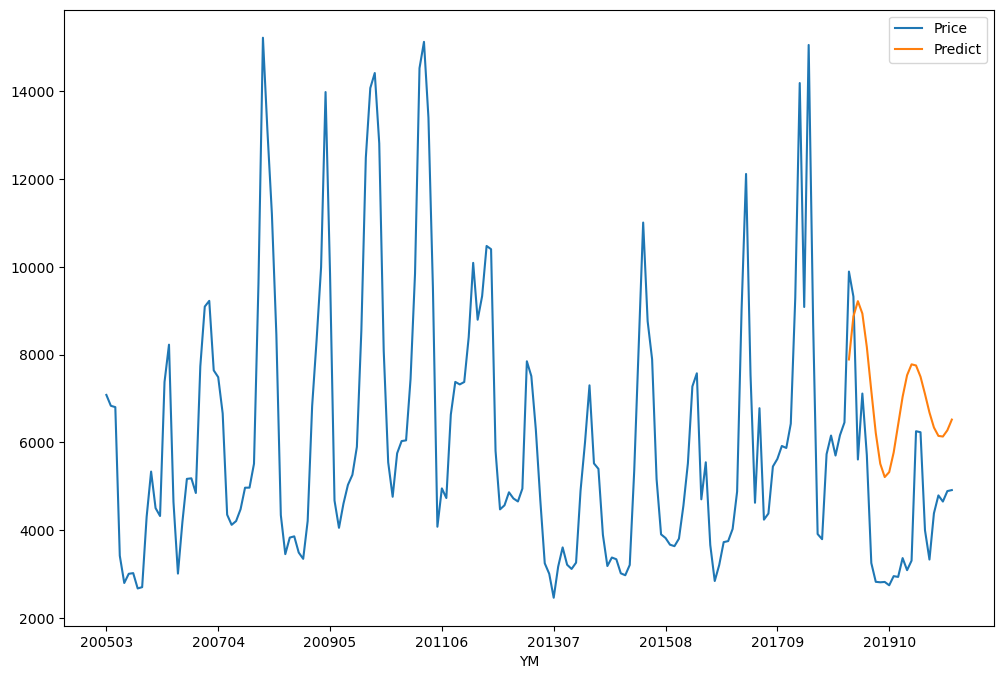

In [40]:
potato['Predict']=history.predict(start=train_idx, end=train_idx+test_idx-1, dynamic=True)
potato[['Price','Predict']].plot(figsize=(12,8))

In [41]:
y_true = potato[~potato['Predict'].isna()]['Price']
y_pred = potato[~potato['Predict'].isna()]['Predict']

mape = np.mean(np.abs(y_pred - y_true) / np.abs(y_true))
mae = np.mean(np.abs(y_pred - y_true))
mpe = np.mean((y_pred-y_true)/y_true)
rmse = np.mean((y_pred - y_true)**2)**.5


pprint.pprint({'mape':mape, 'mae':mae,
       'mpe':mpe, 'rmse':rmse})

{'mae': 2551.7845716985657,
 'mape': 0.6940730506788989,
 'mpe': 0.6731493235717184,
 'rmse': 2766.1376326580375}


# SARIMAX Model

# PPI CPI 제외하고 학습

C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot: xlabel='YM'>

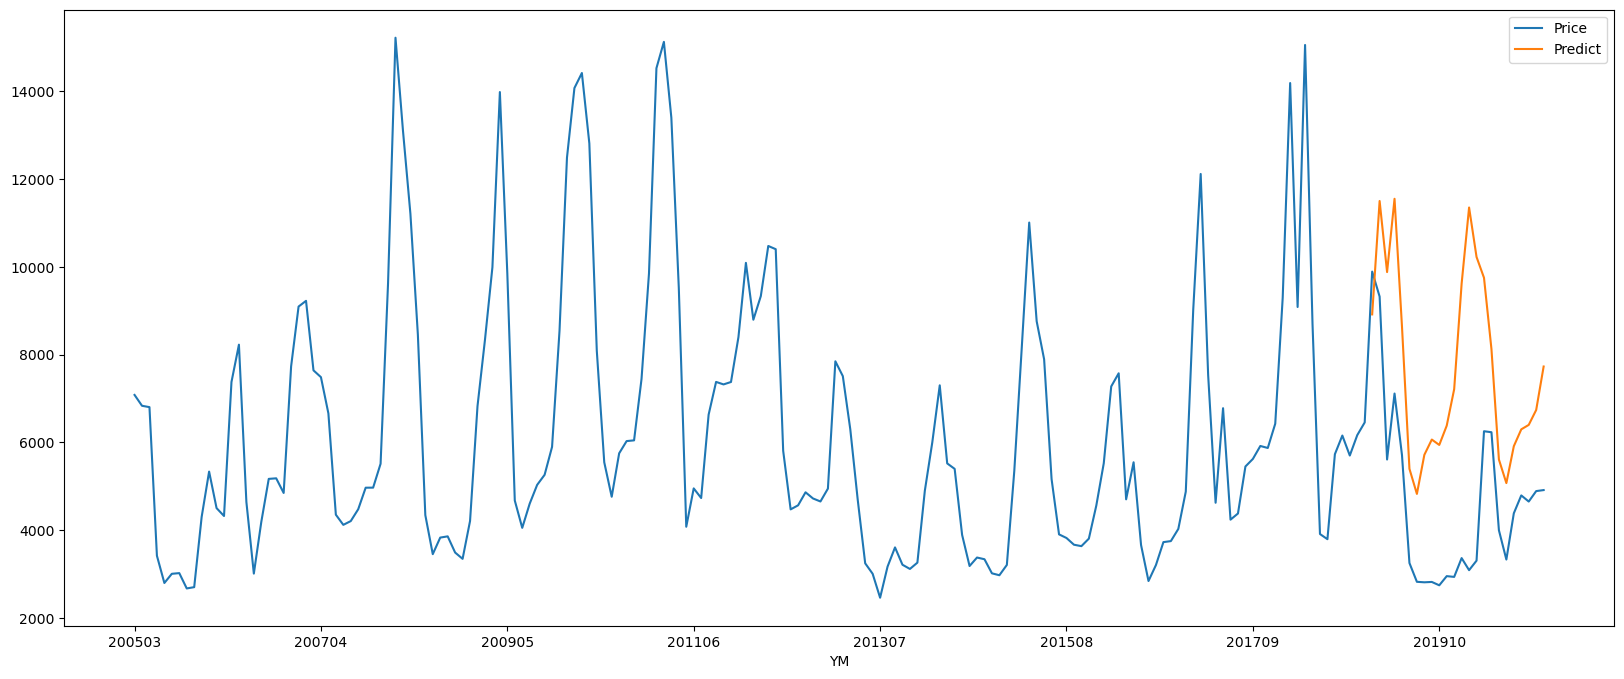

In [42]:
model=sm.tsa.statespace.SARIMAX(potato['Price'],
                                exog=potato_exog[['Annual_Call_Rate', 'KRW_USD_EXR', 'Food_Price_Index', 'Cereals_Price_Index']],
                                order=(2, 1, 2),
                                seasonal_order=(2,1,2,12)
                               )
results=model.fit()

potato['Predict']=results.predict(start=train_idx, end=train_idx+test_idx-1, dynamic=True)
potato[['Price','Predict']].plot(figsize=(20,8))

In [43]:
y_true = potato[~potato['Predict'].isna()]['Price']
y_pred = potato[~potato['Predict'].isna()]['Predict']

mape = np.mean(np.abs(y_pred - y_true) / np.abs(y_true))
mae = np.mean(np.abs(y_pred - y_true))
mpe = np.mean((y_pred-y_true)/y_true)
rmse = np.mean((y_pred - y_true)**2)**.5


pprint.pprint({'mape':mape, 'mae':mae,
       'mpe':mpe, 'rmse':rmse})

{'mae': 3152.421700718291,
 'mape': 0.8331332275188664,
 'mpe': 0.8249100975891751,
 'rmse': 3629.2717637187375}


# PPI CPI로만 학습

C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot: xlabel='YM'>

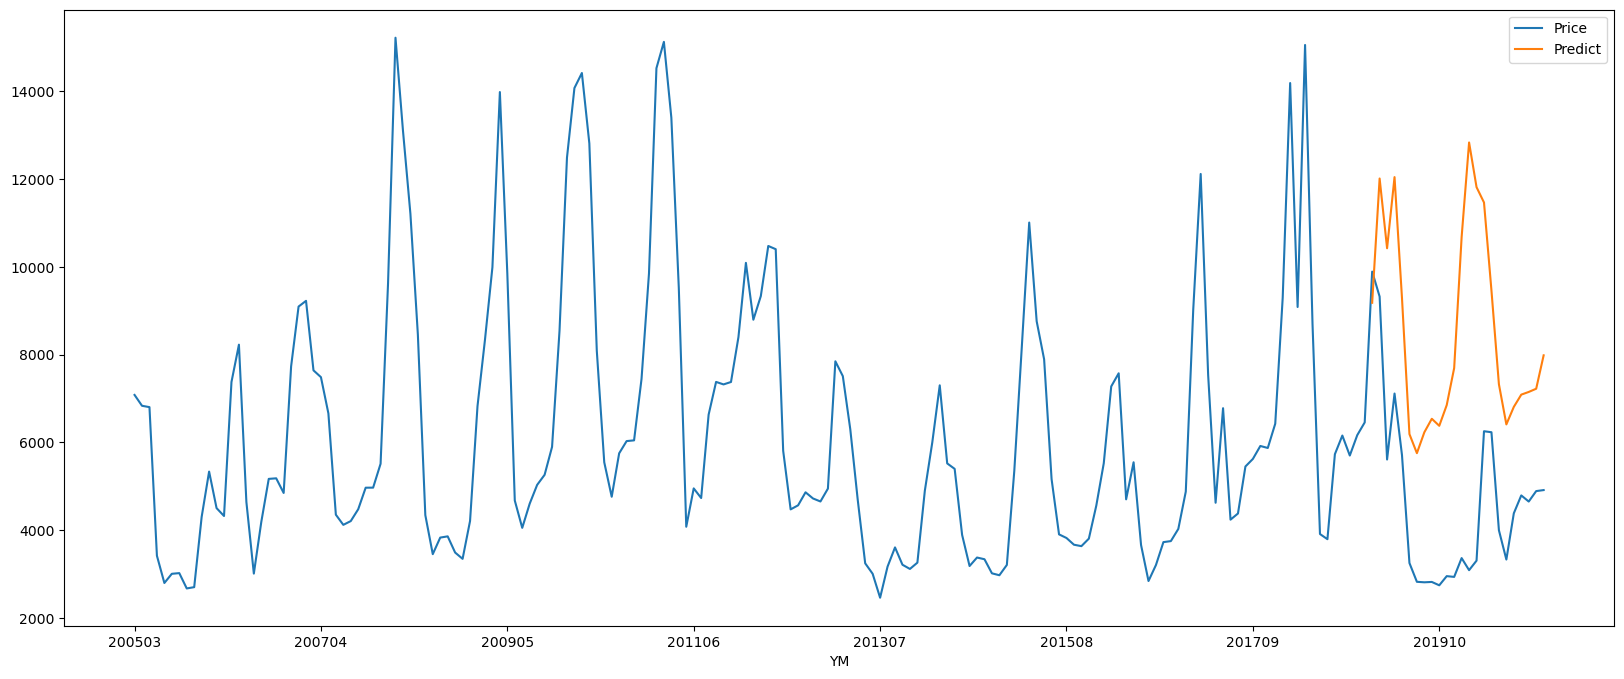

In [44]:
model=sm.tsa.statespace.SARIMAX(potato['Price'],
                                exog=potato_exog[['item_CPI', 'item_PPI']],
                                order=(2, 1, 2),
                                seasonal_order=(2,1,2,12)
                               )
results=model.fit()

potato['Predict']=results.predict(start=train_idx, end=train_idx+test_idx-1, dynamic=True)
potato[['Price','Predict']].plot(figsize=(20,8))

In [45]:
y_true = potato[~potato['Predict'].isna()]['Price']
y_pred = potato[~potato['Predict'].isna()]['Predict']

mape = np.mean(np.abs(y_pred - y_true) / np.abs(y_true))
mae = np.mean(np.abs(y_pred - y_true))
mpe = np.mean((y_pred-y_true)/y_true)
rmse = np.mean((y_pred - y_true)**2)**.5


pprint.pprint({'mape':mape, 'mae':mae,
       'mpe':mpe, 'rmse':rmse})

{'mae': 3963.024232731533,
 'mape': 1.041294448232502,
 'mpe': 1.035302232644197,
 'rmse': 4442.410713130591}


# 모든 Feature로 학습

C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot: xlabel='YM'>

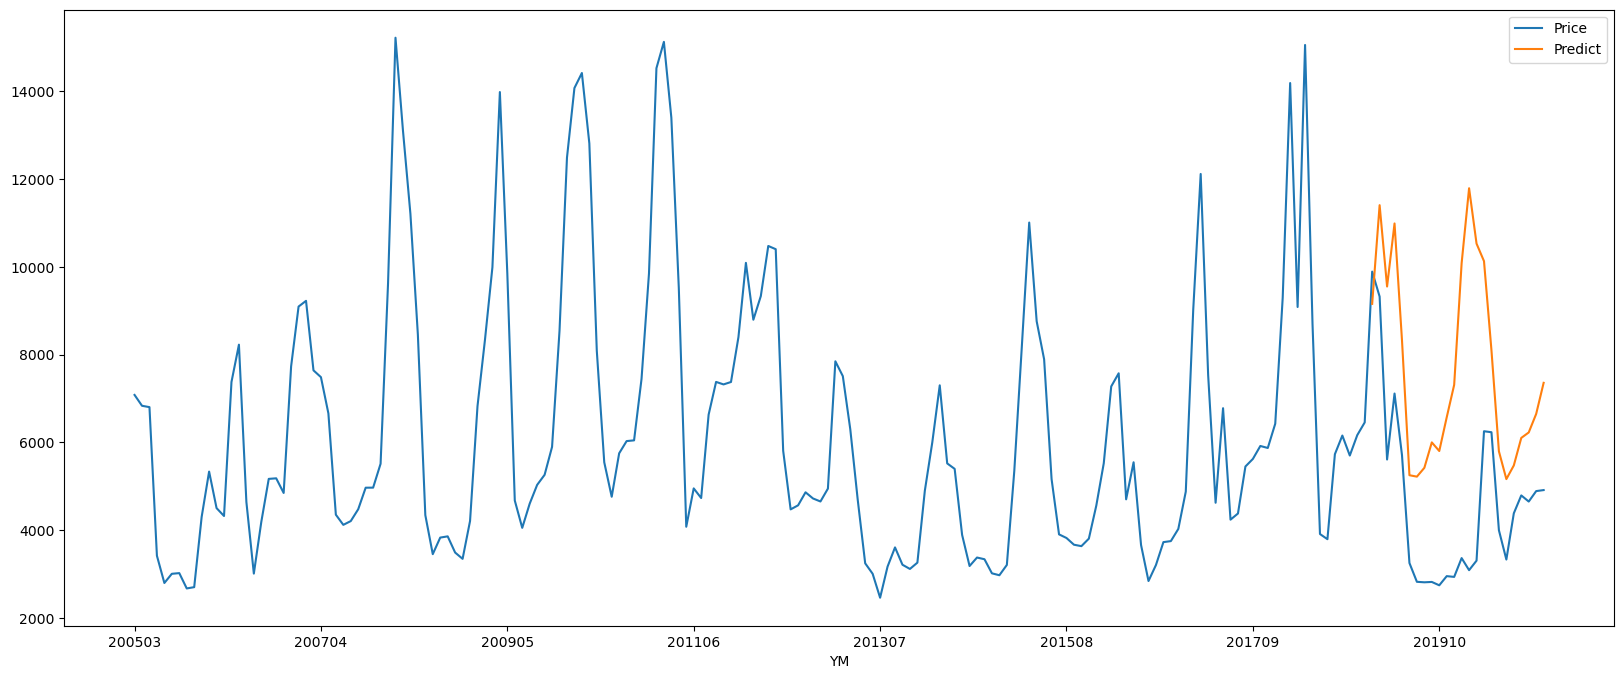

In [46]:
model=sm.tsa.statespace.SARIMAX(potato['Price'],
                                exog=potato_exog,
                                order=(2, 1, 2),
                                seasonal_order=(2,1,2,12)
                               )
results=model.fit()

potato['Predict']=results.predict(start=train_idx, end=train_idx+test_idx-1, dynamic=True)
potato[['Price','Predict']].plot(figsize=(20,8))

In [47]:
y_true = potato[~potato['Predict'].isna()]['Price']
y_pred = potato[~potato['Predict'].isna()]['Predict']

mape = np.mean(np.abs(y_pred - y_true) / np.abs(y_true))
mae = np.mean(np.abs(y_pred - y_true))
mpe = np.mean((y_pred-y_true)/y_true)
rmse = np.mean((y_pred - y_true)**2)**.5


pprint.pprint({'mape':mape, 'mae':mae,
       'mpe':mpe, 'rmse':rmse})

{'mae': 3113.8665767854304,
 'mape': 0.833946966750914,
 'mpe': 0.8277478972198639,
 'rmse': 3671.5862556389397}


# 고구마

In [48]:
sweetpotato = df.loc[df['Product']=='고구마']
sweetpotato = pd.DataFrame(sweetpotato.groupby('YM').mean())
sweetpotato[['item_CPI', 'item_PPI']] = sweetpotato_sub[['item_CPI', 'item_PPI']]
sweetpotato_exog = sweetpotato.iloc[:, 2:8]
sweetpotato = pd.DataFrame(sweetpotato.iloc[:, 1])
sweetpotato

Price
YM                  
200503   5012.198732
200504   5563.116631
200505   5939.400333
200506   5804.732592
200507   7025.797781
...              ...
202008  14122.158248
202009  10522.090488
202010   9244.383846
202011   9584.905475
202012  10112.260484

[190 rows x 1 columns]

<AxesSubplot: xlabel='YM'>

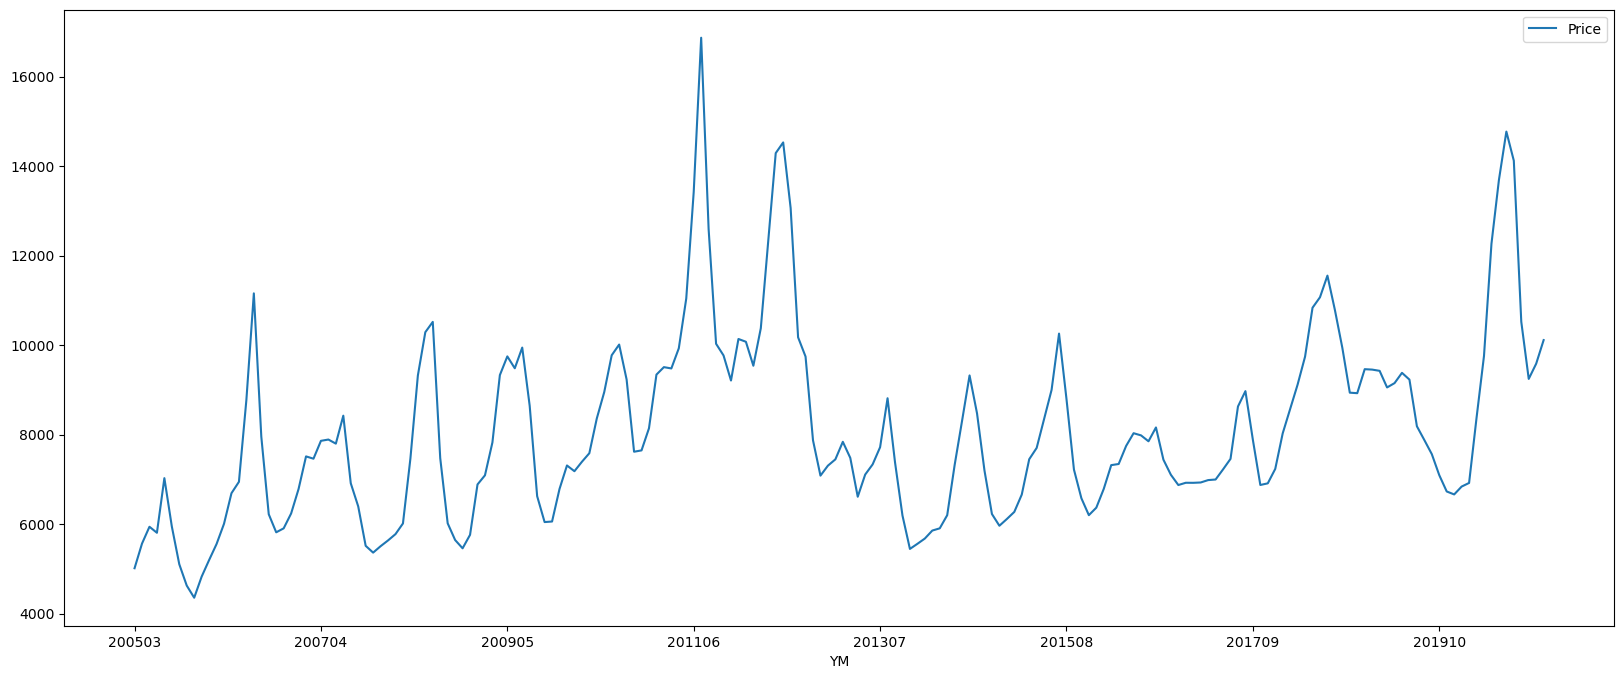

In [49]:
sweetpotato.plot(figsize=(20,8))

In [50]:
sweetpotato_train = sweetpotato.iloc[:train_idx]
sweetpotato_test = sweetpotato.iloc[train_idx:]

C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


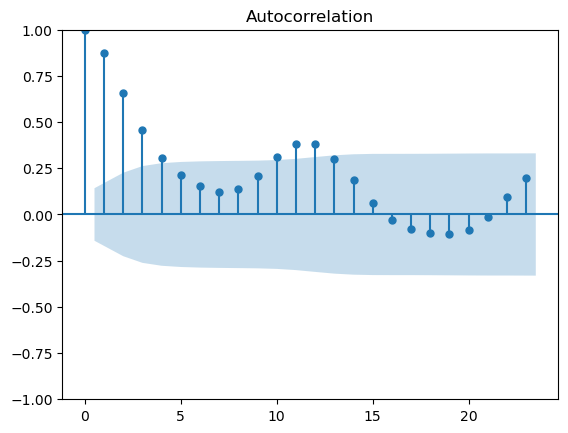

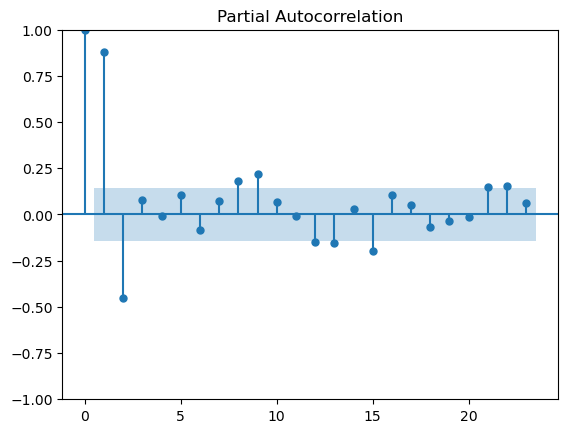

In [51]:
plot_acf(sweetpotato)
plot_pacf(sweetpotato)
plt.show()

C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


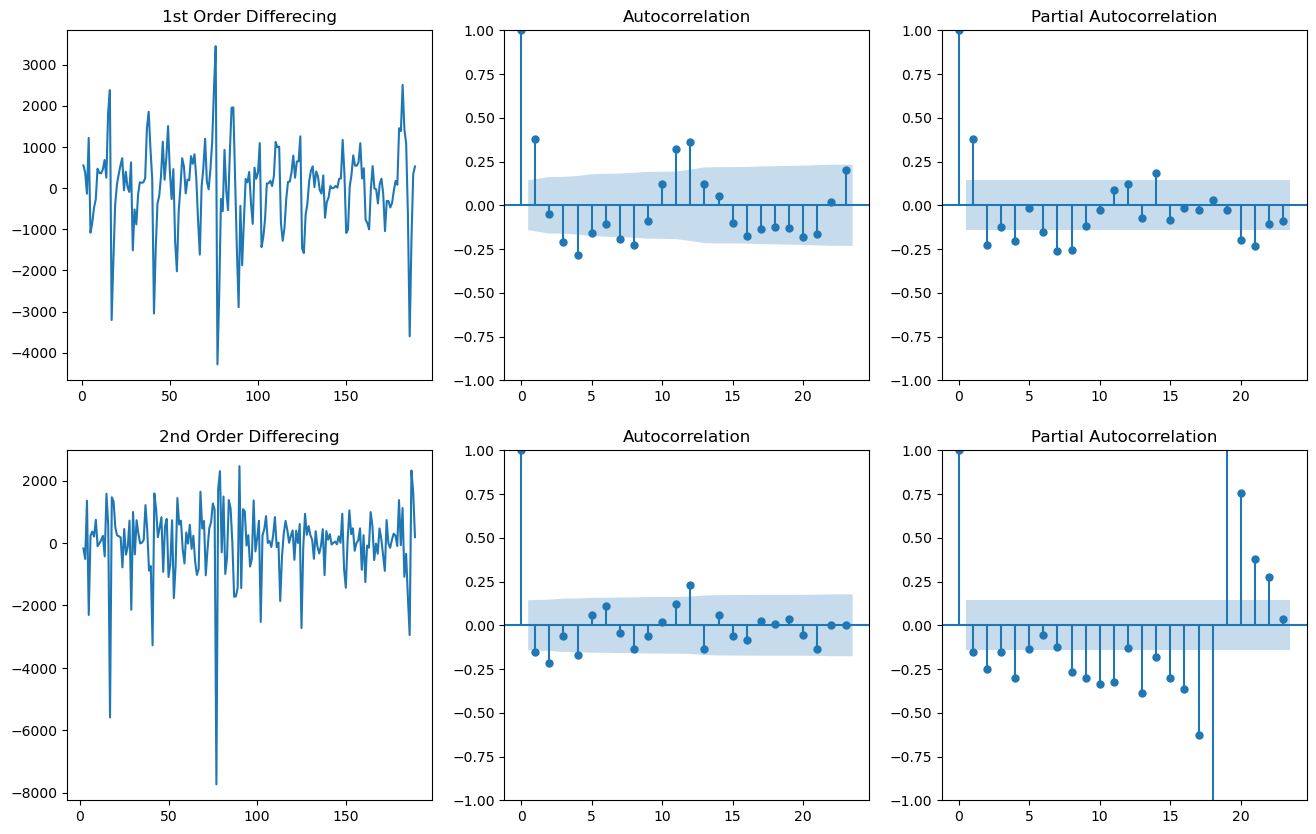

p-value:  0.0872026632415252
1st Order Diff p-value:  0.027712528199852943
2nd Order Diff p-value:  1.7189688451783814e-16


In [52]:
sweetpotato = sweetpotato.reset_index()

f = plt.figure(figsize=(16,10))
ax1 = f.add_subplot(231)
ax1.set_title('1st Order Differecing')
ax1.plot(sweetpotato.Price.diff())

ax2 = f.add_subplot(232)
plot_acf(sweetpotato.Price.diff().dropna(), ax=ax2)

ax3 = f.add_subplot(233)
plot_pacf(sweetpotato.Price.diff().dropna(), ax=ax3)

ax4 = f.add_subplot(234)
ax4.set_title('2nd Order Differecing')
ax4.plot(sweetpotato.Price.diff().diff())

ax5 = f.add_subplot(235)
plot_acf(sweetpotato.Price.diff().diff().dropna(), ax=ax5)

ax6 = f.add_subplot(236)
plot_pacf(sweetpotato.Price.diff().diff().dropna(), ax=ax6)

plt.show()

sweetpotato.index=sweetpotato['YM']
sweetpotato = sweetpotato.drop('YM', axis=1)

result = adfuller(sweetpotato.Price.dropna())
print('p-value: ', result[1])

result = adfuller(sweetpotato.Price.diff().dropna())
print('1st Order Diff p-value: ', result[1])

result = adfuller(sweetpotato.Price.diff().diff().dropna())
print('2nd Order Diff p-value: ', result[1])

# ARIMA Model

In [53]:
model=ARIMA(sweetpotato['Price'], order=(2,1,2))
history=model.fit()

C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [54]:
history.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  190
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1551.328
Date:                Wed, 04 Jan 2023   AIC                           3112.656
Time:                        18:51:58   BIC                           3128.865
Sample:                             0   HQIC                          3119.223
                                - 190                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2089      0.147      8.235      0.000       0.921       1.497
ar.L2         -0.5045      0.154     -3.286      0.001      -0.805      -0.204
ma.L1         -0.8843      0.184     -4.794      0.000      -1.246      -0.523
ma.L2          0.0150      0.204      0.073      0.941      -0.386       0.416
sigma2      8.462e+05   6.21e+04     13.635      0.000    7.25e+05    9.68e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               222.03
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                            -0.85
Prob(H) (two-sided):                  0.02   Kurtosis:                         8.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot: xlabel='YM'>

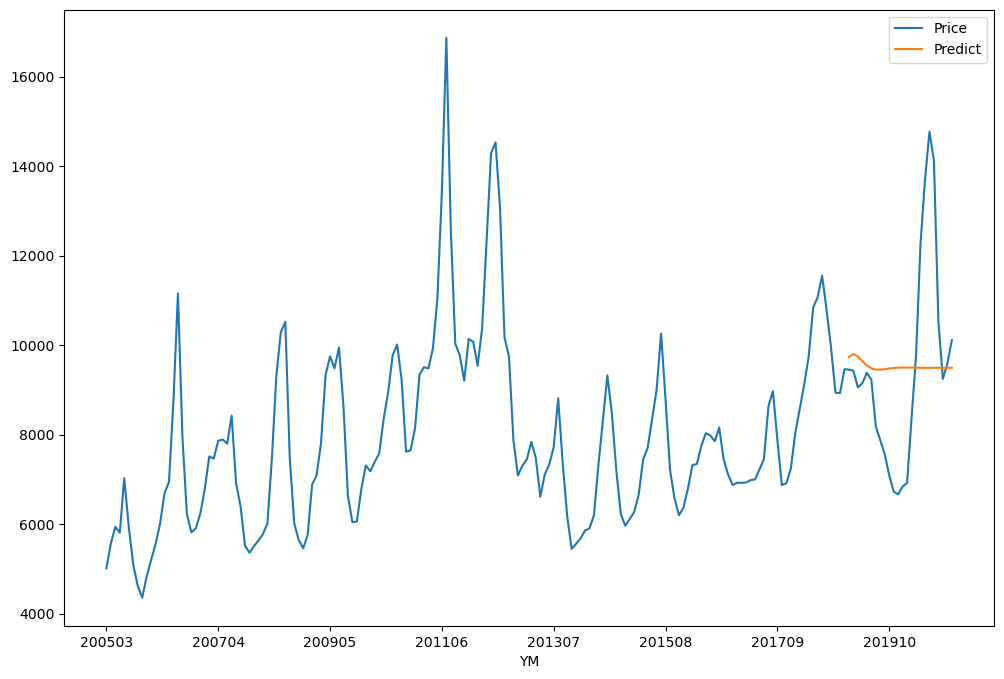

In [55]:
sweetpotato['Predict']=history.predict(start=train_idx, end=train_idx+test_idx-1, dynamic=True)
sweetpotato[['Price','Predict']].plot(figsize=(12,8))

In [56]:
y_true = sweetpotato[~sweetpotato['Predict'].isna()]['Price']
y_pred = sweetpotato[~sweetpotato['Predict'].isna()]['Predict']

mape = np.mean(np.abs(y_pred - y_true) / np.abs(y_true))
mae = np.mean(np.abs(y_pred - y_true))
mpe = np.mean((y_pred-y_true)/y_true)
rmse = np.mean((y_pred - y_true)**2)**.5


pprint.pprint({'mape':mape, 'mae':mae,
       'mpe':mpe, 'rmse':rmse})

{'mae': 1686.3337389771978,
 'mape': 0.18161889697068034,
 'mpe': 0.06382408151758624,
 'rmse': 2247.737892861377}


# SARIMAX Model

# PPI CPI 제외하고 학습

C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot: xlabel='YM'>

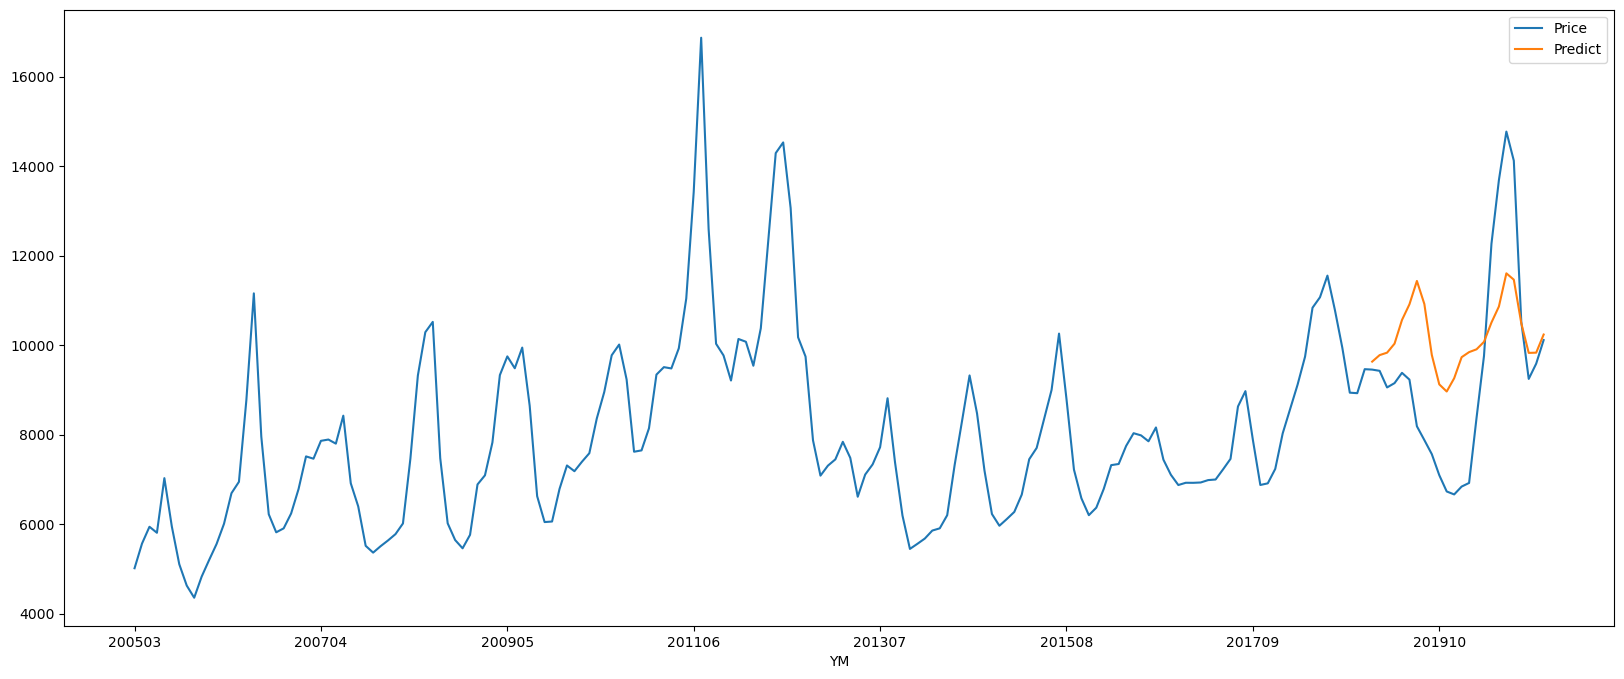

In [57]:
model=sm.tsa.statespace.SARIMAX(sweetpotato['Price'],
                                exog=sweetpotato_exog[['Annual_Call_Rate', 'KRW_USD_EXR', 'Food_Price_Index', 'Cereals_Price_Index']],
                                order=(2, 1, 2),
                                seasonal_order=(2,1,2,12)
                               )
results=model.fit()

sweetpotato['Predict']=results.predict(start=train_idx,end=train_idx+test_idx-1,dynamic=True)
sweetpotato[['Price','Predict']].plot(figsize=(20,8))

In [58]:
y_true = sweetpotato[~sweetpotato['Predict'].isna()]['Price']
y_pred = sweetpotato[~sweetpotato['Predict'].isna()]['Predict']

mape = np.mean(np.abs(y_pred - y_true) / np.abs(y_true))
mae = np.mean(np.abs(y_pred - y_true))
mpe = np.mean((y_pred-y_true)/y_true)
rmse = np.mean((y_pred - y_true)**2)**.5


pprint.pprint({'mape':mape, 'mae':mae,
       'mpe':mpe, 'rmse':rmse})

{'mae': 1645.1172690310825,
 'mape': 0.1895185799396245,
 'mpe': 0.12653531734894935,
 'rmse': 1982.4237661335471}


# PPI CPI로만 학습

C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot: xlabel='YM'>

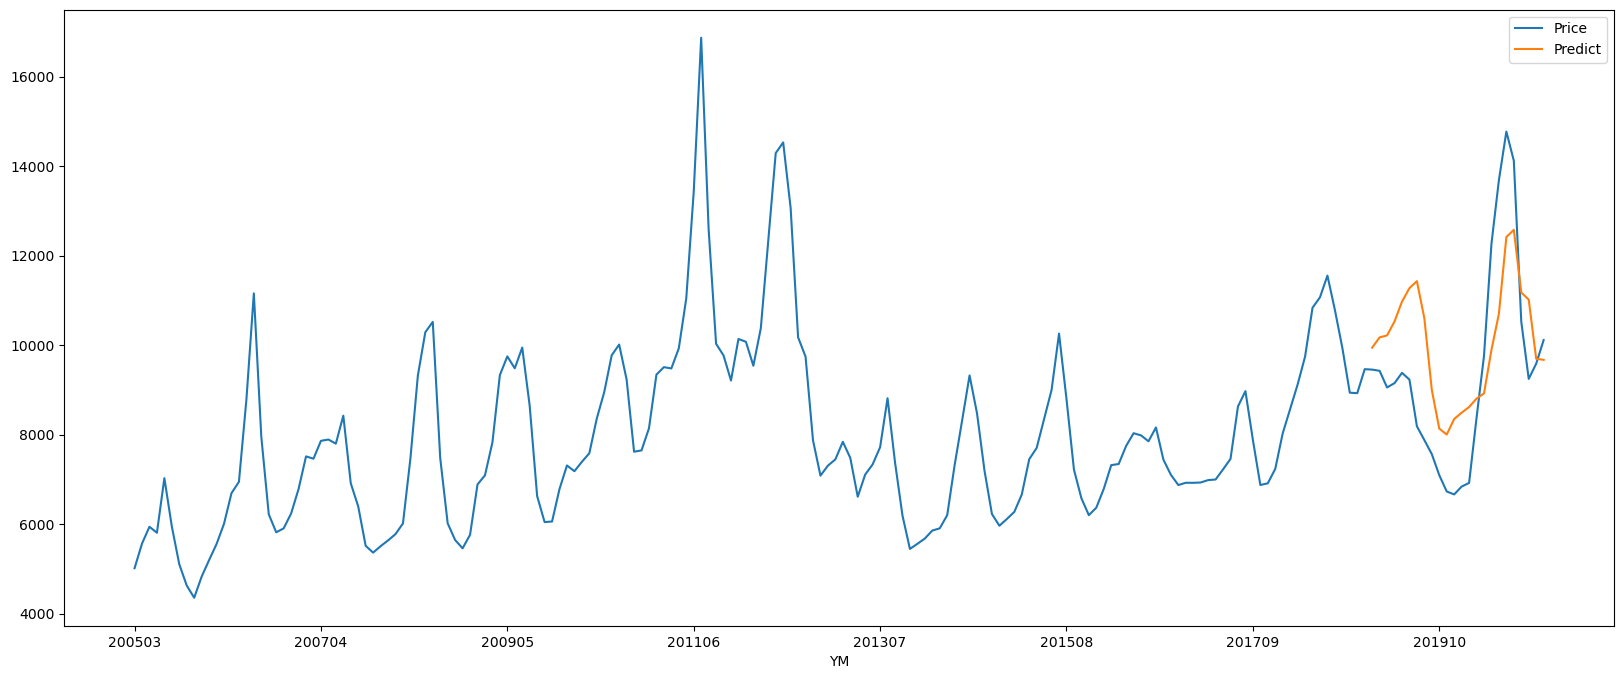

In [59]:
model=sm.tsa.statespace.SARIMAX(sweetpotato['Price'],
                                exog=sweetpotato_exog[['item_CPI', 'item_PPI']],
                                order=(2, 1, 2),
                                seasonal_order=(2,1,2,12)
                               )
results=model.fit()

sweetpotato['Predict']=results.predict(start=train_idx,end=train_idx+test_idx-1,dynamic=True)
sweetpotato[['Price','Predict']].plot(figsize=(20,8))

In [60]:
y_true = sweetpotato[~sweetpotato['Predict'].isna()]['Price']
y_pred = sweetpotato[~sweetpotato['Predict'].isna()]['Predict']

mape = np.mean(np.abs(y_pred - y_true) / np.abs(y_true))
mae = np.mean(np.abs(y_pred - y_true))
mpe = np.mean((y_pred-y_true)/y_true)
rmse = np.mean((y_pred - y_true)**2)**.5


pprint.pprint({'mape':mape, 'mae':mae,
       'mpe':mpe, 'rmse':rmse})

{'mae': 1486.3114331979111,
 'mape': 0.16399016778968542,
 'mpe': 0.09648410978279265,
 'rmse': 1696.322525041503}


# 모든 Feature로 학습

C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot: xlabel='YM'>

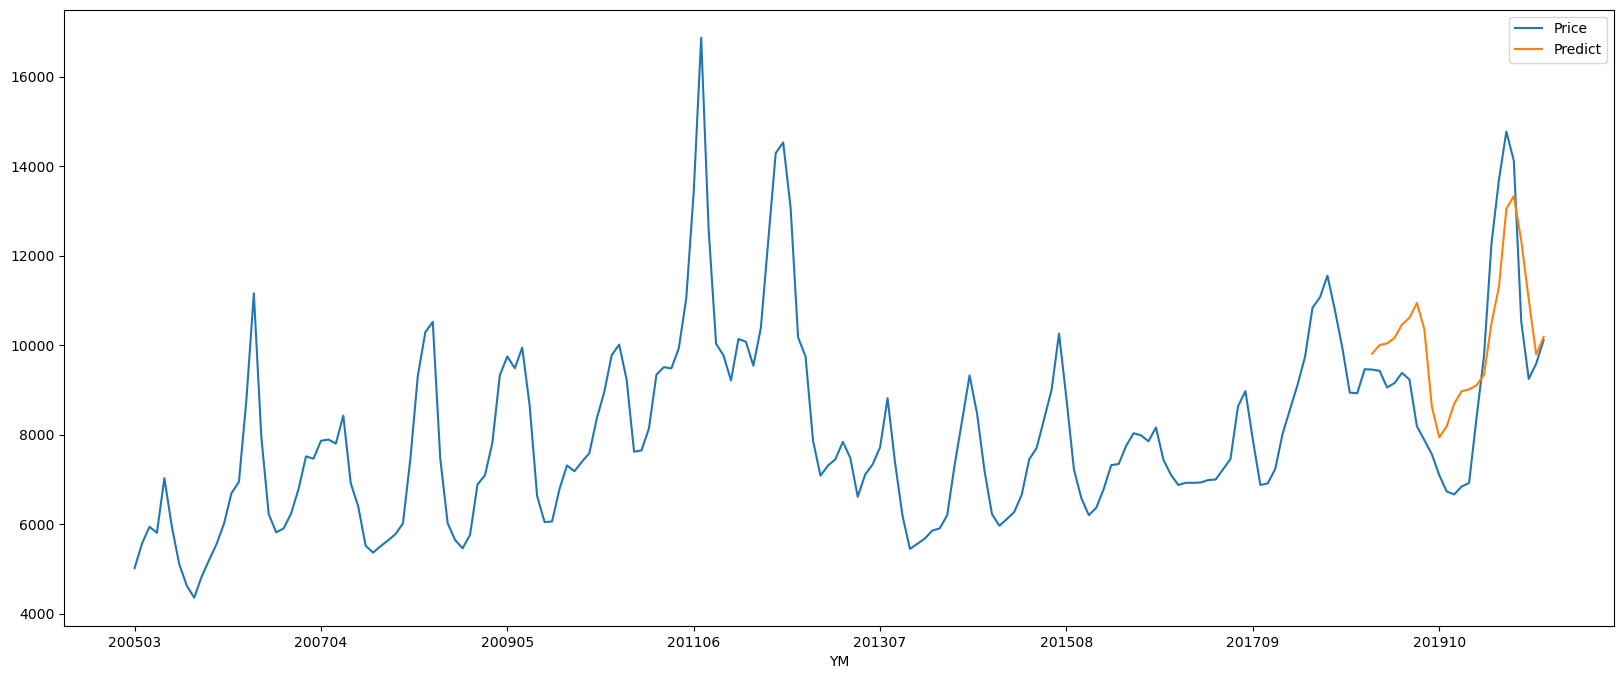

In [61]:
model=sm.tsa.statespace.SARIMAX(sweetpotato['Price'],
                                exog=sweetpotato_exog,
                                order=(2, 1, 2),
                                seasonal_order=(2,1,2,12)
                               )
results=model.fit()

sweetpotato['Predict']=results.predict(start=train_idx,end=train_idx+test_idx-1,dynamic=True)
sweetpotato[['Price','Predict']].plot(figsize=(20,8))

In [62]:
y_true = sweetpotato[~sweetpotato['Predict'].isna()]['Price']
y_pred = sweetpotato[~sweetpotato['Predict'].isna()]['Predict']

mape = np.mean(np.abs(y_pred - y_true) / np.abs(y_true))
mae = np.mean(np.abs(y_pred - y_true))
mpe = np.mean((y_pred-y_true)/y_true)
rmse = np.mean((y_pred - y_true)**2)**.5


pprint.pprint({'mape':mape, 'mae':mae,
       'mpe':mpe, 'rmse':rmse})

{'mae': 1331.0529631663628,
 'mape': 0.1518740494292893,
 'mpe': 0.10722899558209649,
 'rmse': 1526.7926466938245}


# 깻잎

In [63]:
perilla = df.loc[df['Product']=='깻잎']
perilla = pd.DataFrame(perilla.groupby('YM').mean())
perilla[['item_CPI', 'item_PPI']] = perilla_sub[['item_CPI', 'item_PPI']]
perilla_exog = perilla.iloc[:, 2:8]
perilla_exog = perilla_exog.drop('item_PPI', axis=1)
perilla = pd.DataFrame(perilla.iloc[:, 1])
perilla

Price
YM                 
200503  3670.232558
200504  3165.027685
200505  2880.517970
200506  2420.387597
200507  3427.377088
...             ...
202008  7877.928315
202009  7777.987711
202010  5083.387514
202011  4258.717358
202012  5158.485785

[190 rows x 1 columns]

<AxesSubplot: xlabel='YM'>

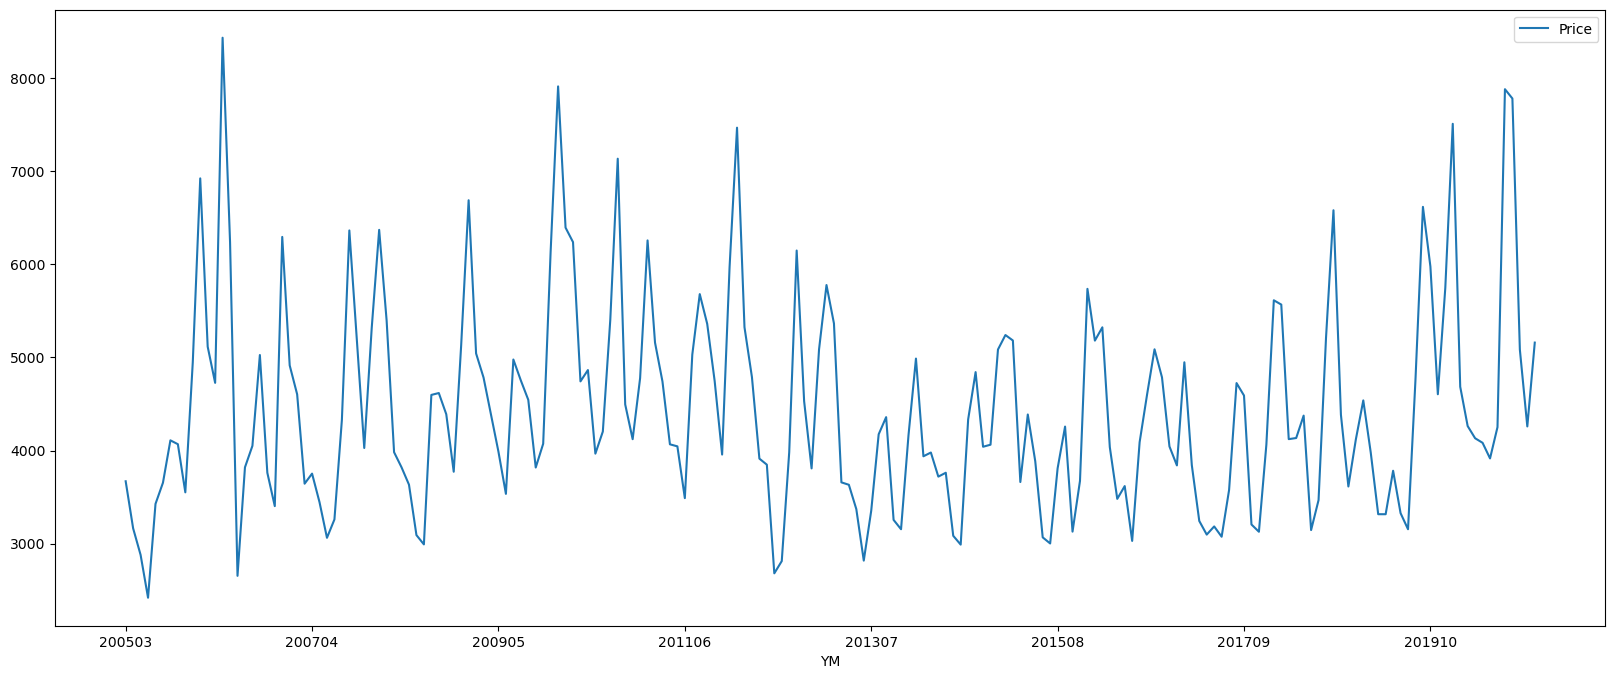

In [64]:
perilla.plot(figsize=(20,8))

In [65]:
perilla_train = perilla.iloc[:train_idx]
perilla_test = perilla.iloc[train_idx:]

C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


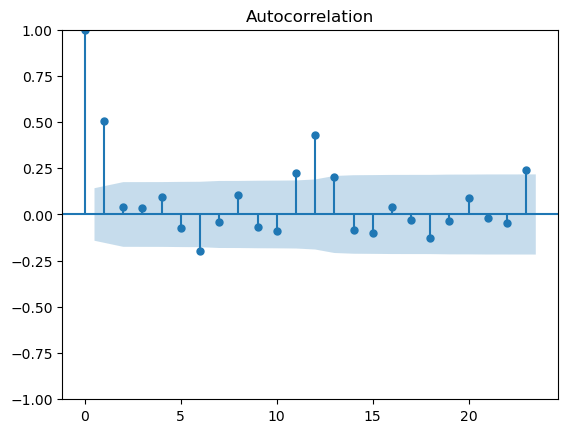

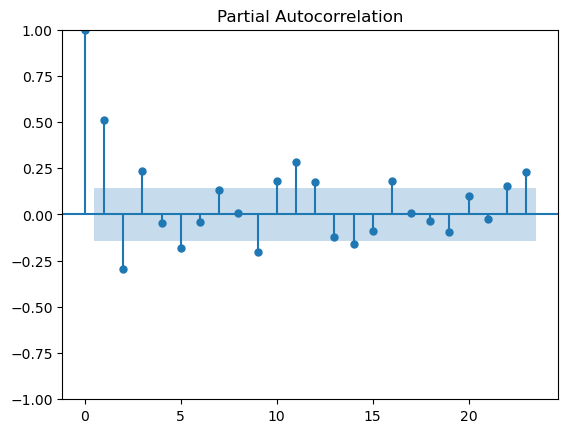

In [66]:
plot_acf(perilla)
plot_pacf(perilla)
plt.show()

C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


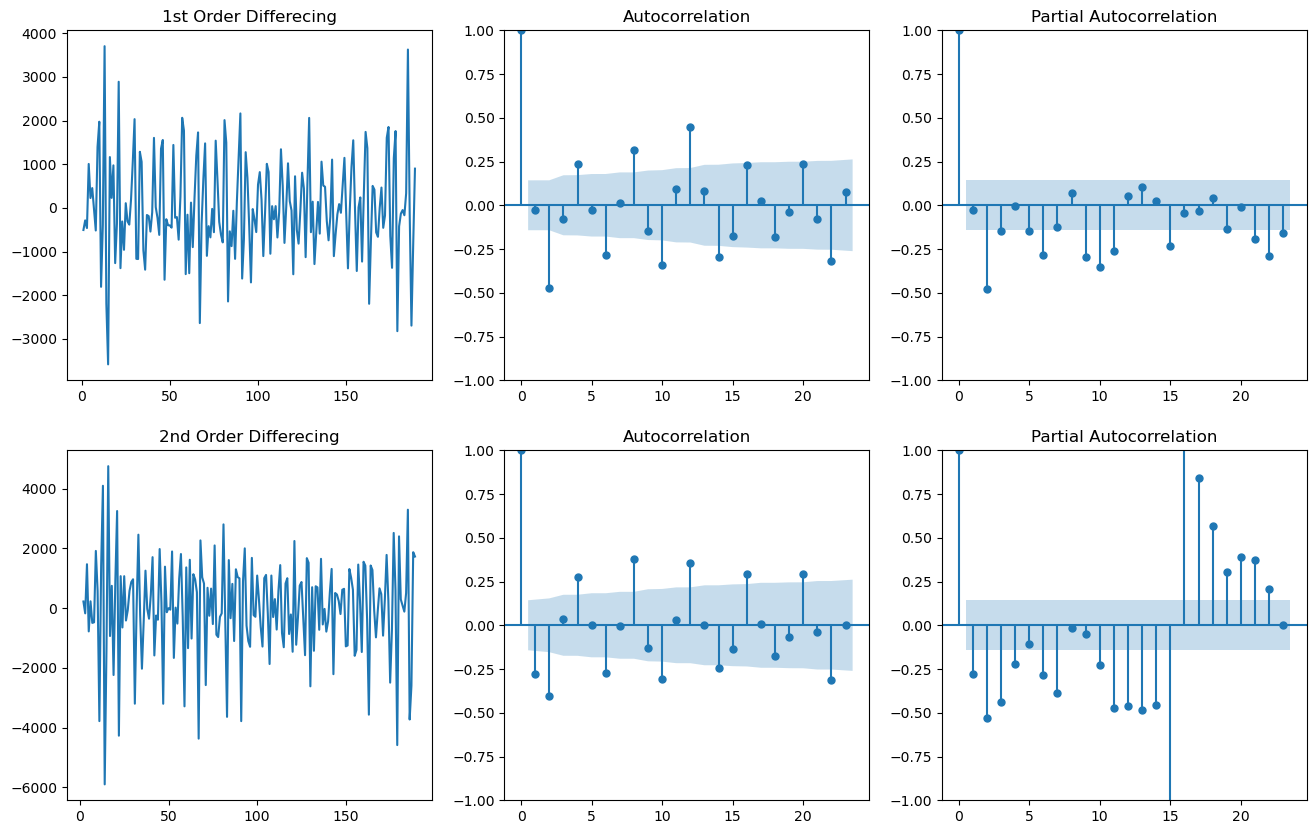

p-value:  0.3343482873978645
1st Order Diff p-value:  7.747138795014251e-07
2nd Order Diff p-value:  5.396317326862709e-11


In [67]:
perilla = perilla.reset_index()

f = plt.figure(figsize=(16,10))
ax1 = f.add_subplot(231)
ax1.set_title('1st Order Differecing')
ax1.plot(perilla.Price.diff())

ax2 = f.add_subplot(232)
plot_acf(perilla.Price.diff().dropna(), ax=ax2)

ax3 = f.add_subplot(233)
plot_pacf(perilla.Price.diff().dropna(), ax=ax3)

ax4 = f.add_subplot(234)
ax4.set_title('2nd Order Differecing')
ax4.plot(perilla.Price.diff().diff())

ax5 = f.add_subplot(235)
plot_acf(perilla.Price.diff().diff().dropna(), ax=ax5)

ax6 = f.add_subplot(236)
plot_pacf(perilla.Price.diff().diff().dropna(), ax=ax6)

plt.show()

perilla.index=perilla['YM']
perilla = perilla.drop('YM', axis=1)

result = adfuller(perilla.Price.dropna())
print('p-value: ', result[1])

result = adfuller(perilla.Price.diff().dropna())
print('1st Order Diff p-value: ', result[1])

result = adfuller(perilla.Price.diff().diff().dropna())
print('2nd Order Diff p-value: ', result[1])

# ARIMA Model

In [68]:
model=ARIMA(perilla['Price'],order=(1,1,1))
history=model.fit()

C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [69]:
history.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  190
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1572.983
Date:                Wed, 04 Jan 2023   AIC                           3151.965
Time:                        18:52:13   BIC                           3161.691
Sample:                             0   HQIC                          3155.905
                                - 190                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5252      0.064      8.259      0.000       0.401       0.650
ma.L1         -1.0000      0.076    -13.240      0.000      -1.148      -0.852
sigma2      9.637e+05   7.84e-08   1.23e+13      0.000    9.64e+05    9.64e+05
===================================================================================
Ljung-Box (L1) (Q):                   4.05   Jarque-Bera (JB):                54.82
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                             1.04
Prob(H) (two-sided):                  0.35   Kurtosis:                         4.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.07e+27. Standard errors may be unstable.
"""

<AxesSubplot: xlabel='YM'>

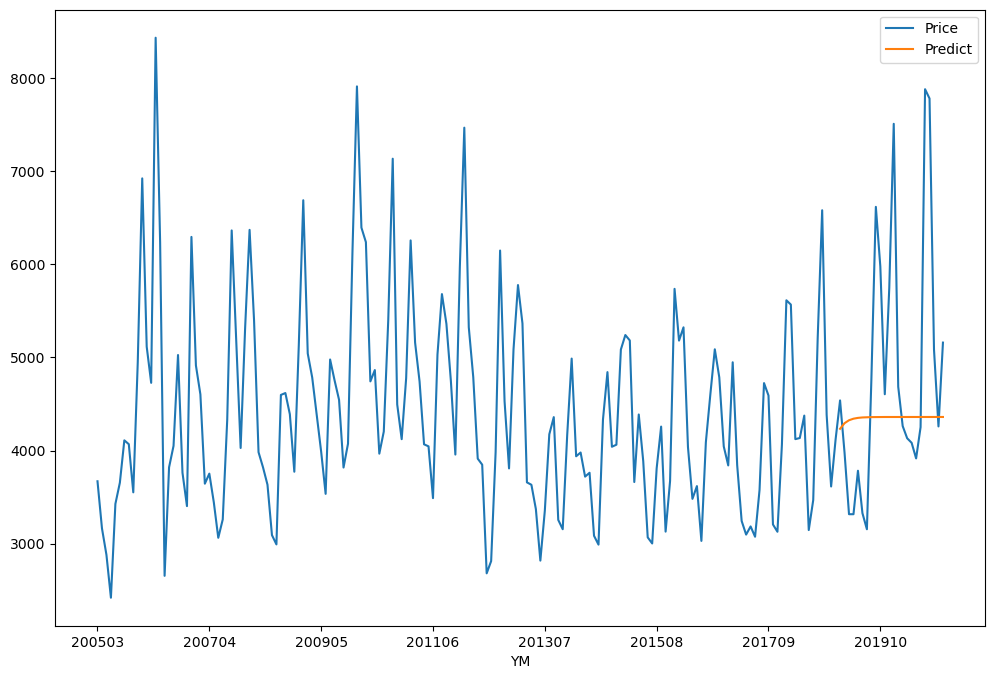

In [70]:
perilla['Predict']=history.predict(start=train_idx, end=train_idx+test_idx-1, dynamic=True)
perilla[['Price','Predict']].plot(figsize=(12,8))

In [71]:
y_true = perilla[~perilla['Predict'].isna()]['Price']
y_pred = perilla[~perilla['Predict'].isna()]['Predict']

mape = np.mean(np.abs(y_pred - y_true) / np.abs(y_true))
mae = np.mean(np.abs(y_pred - y_true))
mpe = np.mean((y_pred-y_true)/y_true)
rmse = np.mean((y_pred - y_true)**2)**.5


pprint.pprint({'mape':mape, 'mae':mae,
       'mpe':mpe, 'rmse':rmse})

{'mae': 1022.5709056708923,
 'mape': 0.19041524525790873,
 'mpe': -0.03699226852512553,
 'rmse': 1450.6686039924427}


# SARIMAX Model

# PPI CPI 제외하고 학습

C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot: xlabel='YM'>

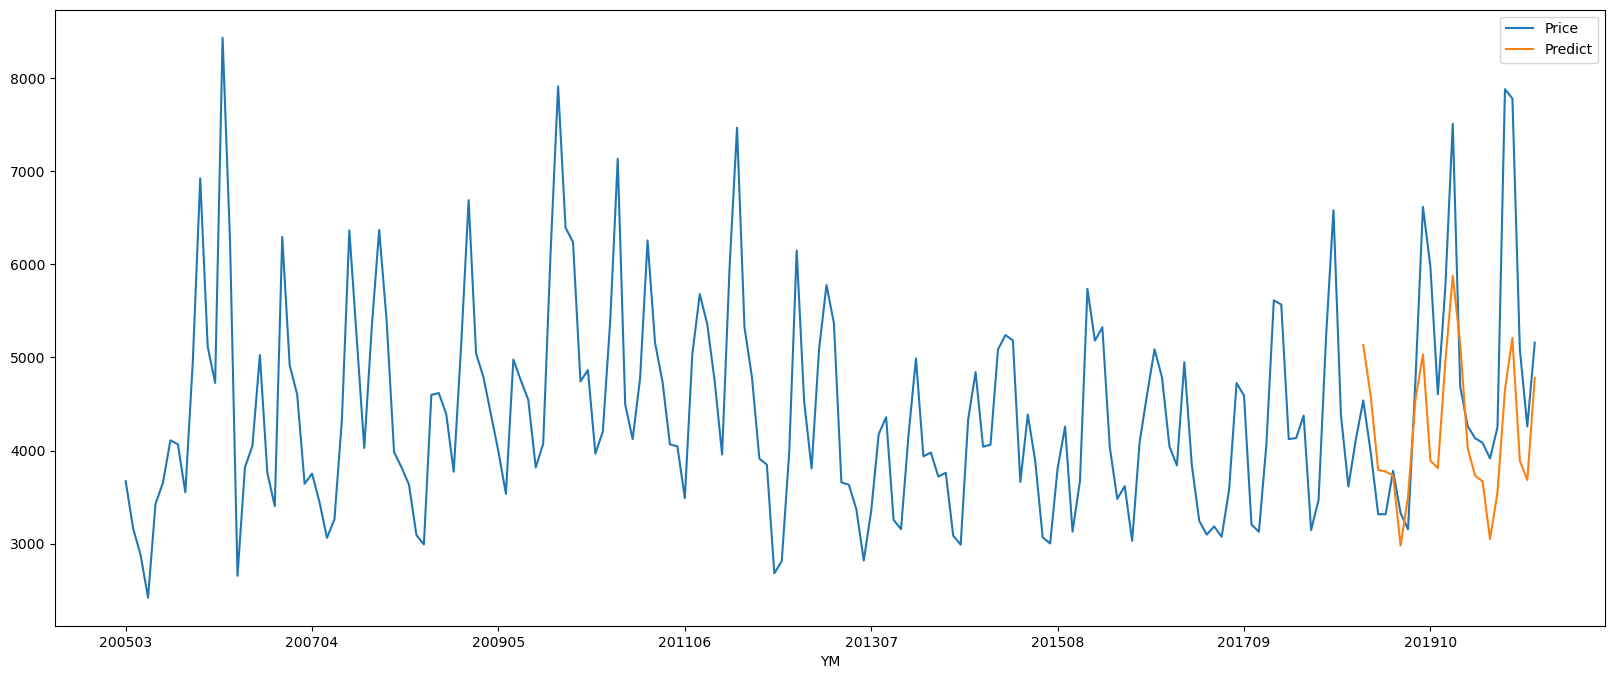

In [72]:
model=sm.tsa.statespace.SARIMAX(perilla['Price'],
                                exog=perilla_exog[['Annual_Call_Rate', 'KRW_USD_EXR', 'Food_Price_Index', 'Cereals_Price_Index']],
                                order=(1, 1, 1),
                                seasonal_order=(1,1,1,12)
                               )
results=model.fit()

perilla['Predict']=results.predict(start=train_idx,end=train_idx+test_idx-1,dynamic=True)
perilla[['Price','Predict']].plot(figsize=(20,8))

In [73]:
y_true = perilla[~perilla['Predict'].isna()]['Price']
y_pred = perilla[~perilla['Predict'].isna()]['Predict']

mape = np.mean(np.abs(y_pred - y_true) / np.abs(y_true))
mae = np.mean(np.abs(y_pred - y_true))
mpe = np.mean((y_pred-y_true)/y_true)
rmse = np.mean((y_pred - y_true)**2)**.5


pprint.pprint({'mape':mape, 'mae':mae,
       'mpe':mpe, 'rmse':rmse})

{'mae': 874.9972501353753,
 'mape': 0.16143121756082343,
 'mpe': -0.09704146829766998,
 'rmse': 1172.0988340571635}


# CPI로만 학습 (PPI값이 존재하지 않음)

C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<AxesSubplot: xlabel='YM'>

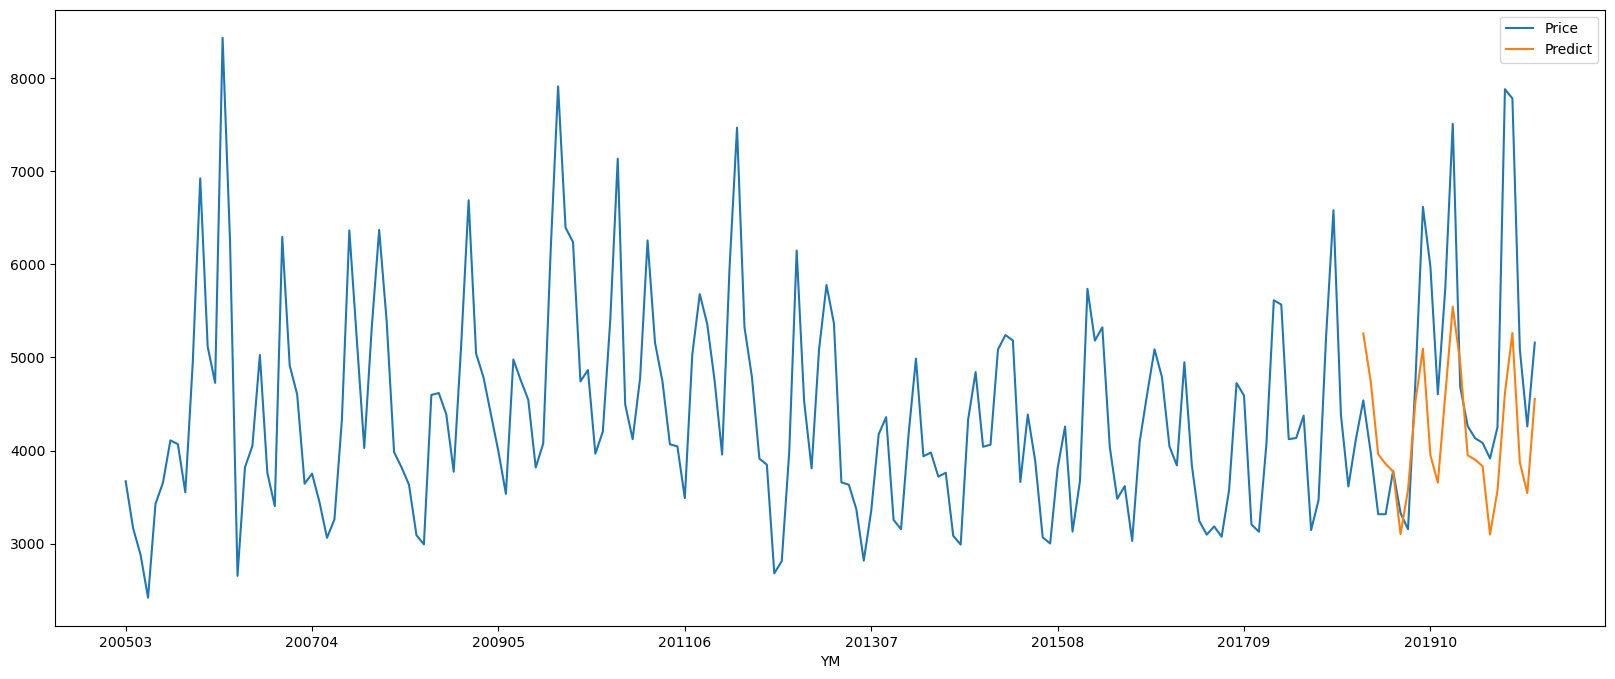

In [74]:
model=sm.tsa.statespace.SARIMAX(perilla['Price'],
                                exog=perilla_exog[['item_CPI']],
                                order=(1, 1, 1),
                                seasonal_order=(1,1,1,12)
                               )
results=model.fit()

perilla['Predict']=results.predict(start=train_idx,end=train_idx+test_idx-1,dynamic=True)
perilla[['Price','Predict']].plot(figsize=(20,8))

In [75]:
y_true = perilla[~perilla['Predict'].isna()]['Price']
y_pred = perilla[~perilla['Predict'].isna()]['Predict']

mape = np.mean(np.abs(y_pred - y_true) / np.abs(y_true))
mae = np.mean(np.abs(y_pred - y_true))
mpe = np.mean((y_pred-y_true)/y_true)
rmse = np.mean((y_pred - y_true)**2)**.5


pprint.pprint({'mape':mape, 'mae':mae,
       'mpe':mpe, 'rmse':rmse})

{'mae': 917.1137183200682,
 'mape': 0.16956789697220684,
 'mpe': -0.0949436597353281,
 'rmse': 1212.4853664204006}


# 모든 Feature로 학습

C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maplexz\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot: xlabel='YM'>

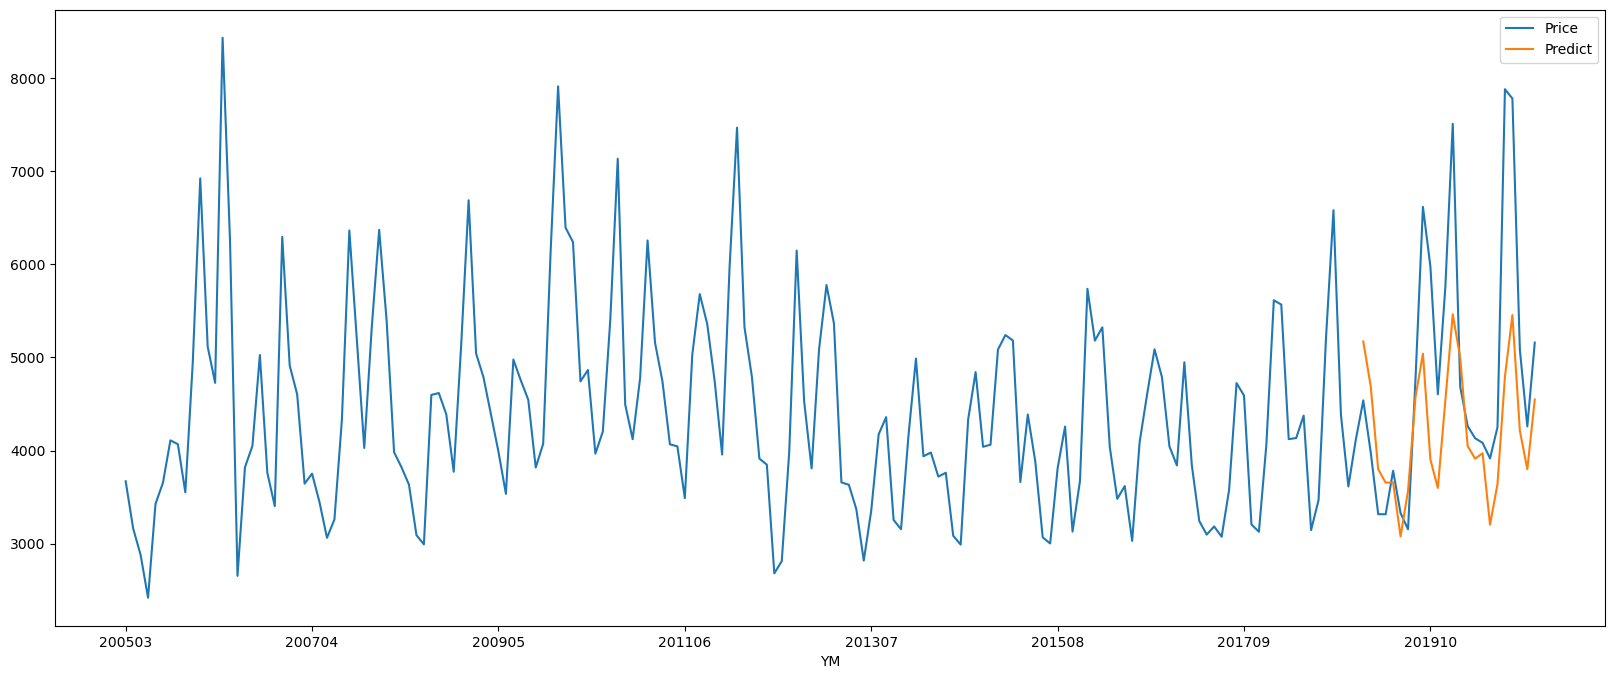

In [76]:
model=sm.tsa.statespace.SARIMAX(perilla['Price'],
                                exog=perilla_exog,
                                order=(1, 1, 1),
                                seasonal_order=(1,1,1,12)
                               )
results=model.fit()

perilla['Predict']=results.predict(start=train_idx,end=train_idx+test_idx-1,dynamic=True)
perilla[['Price','Predict']].plot(figsize=(20,8))

In [77]:
y_true = perilla[~perilla['Predict'].isna()]['Price']
y_pred = perilla[~perilla['Predict'].isna()]['Predict']

mape = np.mean(np.abs(y_pred - y_true) / np.abs(y_true))
mae = np.mean(np.abs(y_pred - y_true))
mpe = np.mean((y_pred-y_true)/y_true)
rmse = np.mean((y_pred - y_true)**2)**.5


pprint.pprint({'mape':mape, 'mae':mae,
       'mpe':mpe, 'rmse':rmse})

{'mae': 857.4731243245218,
 'mape': 0.15588396314709,
 'mpe': -0.09238035270119138,
 'rmse': 1160.3643325810701}
